# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import gseapy
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Global variables

## Load files

### Load pseudobulks

In [2]:
adata_pb = sc.read_h5ad('results/pb_adata_diffexpr.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 321 × 16102
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_colors', 'dendrogram_cluster', 'diagnosis_colors', 'hvg', 'log1p', 'logreg', 'neighbors', 'pca', 'region_colors', 'sample_colors', 't-test', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'psbulk_props'
    obsp: 'connectivities', 'distances'

Create celltypes list

In [3]:
celltypes = adata_pb.obs.cluster.unique().tolist()
celltypes

['AST-FB',
 'AST-PP',
 'Endothelial',
 'IN-PV',
 'IN-SST',
 'IN-SV2C',
 'IN-VIP',
 'L2/3',
 'L4',
 'L5/6',
 'L5/6-CC',
 'Microglia',
 'Neu-NRGN-I',
 'Neu-NRGN-II',
 'Neu-mat',
 'OPC',
 'Oligodendrocytes']

### Load clusters

Load clusters for human-specific genes

In [4]:
cluster_groups = pd.read_csv('../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [5]:
hs_groups = pd.read_csv('../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [6]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

### Load EdgeR results

In [7]:
dirpath = 'results/DE'
res_edgeR = dict()

for file in os.listdir(dirpath):
    # read celltype name
    celltype = file.rstrip('.csv').lstrip('degenes_')
    # read DE results to DataFrame
    df = pd.read_csv(f'{dirpath}/{file}', index_col=0).reset_index(names='names')
    # add a direction to the F-score
    df['score'] = df['F'] * np.heaviside(df['F'], 0) * np.sign(df['logFC'])
    # save to the dict
    res_edgeR[celltype] = df

res_edgeR.keys()

dict_keys(['AST-FB', 'AST-PP', 'Endothelial', 'IN-PV', 'IN-SST', 'IN-SV2C', 'IN-VIP', 'L2.3', 'L4', 'L5.6-CC', 'L5.6', 'Microglia', 'Neu-mat', 'Neu-NRGN-I', 'Neu-NRGN-II', 'Oligodendrocyte', 'OPC'])

In [8]:
res_edgeR['AST-FB'].head()

names     logFC    logCPM            F         PValue            FDR  \
0  FGFR3  6.112733  5.935087  3538.959221  6.070815e-206  1.039323e-201   
1  GPR98  5.307712  8.453964  4706.329229  4.934309e-194  4.223768e-190   
2    AGT  5.584533  4.964741  2249.807283  2.524783e-188  1.440809e-184   
3  PRODH  5.476697  5.163946  2756.795328  5.319866e-187  2.276902e-183   
4   GFAP  5.812645  5.529949  2926.726498  8.565151e-185  2.932708e-181   

         score  
0  3538.959221  
1  4706.329229  
2  2249.807283  
3  2756.795328  
4  2926.726498

### Load chimp-specific genes

Load clusters for chimp-specific genes

In [9]:
chimp_cluster_groups = pd.read_csv('../Specie-specific genes/results/chimp_clusters_edgeR_4.csv', index_col=0)
chimp_cluster_groups.columns = ['label']
chimp_cluster_groups.head()

label
ANK3         0
BCL6         0
RIPOR2       0
TPD52L1      0
ARF5         1

In [10]:
chimp_specific_genes = chimp_cluster_groups.index.to_list()
chimp_specific_genes[:5]

['ANK3', 'BCL6', 'RIPOR2', 'TPD52L1', 'ARF5']

### Load Velmeshev data

In [11]:
adata_velm = sc.read_h5ad('results/adata_velm_umap.h5ad')
adata_velm

AnnData object with n_obs × n_vars = 52556 × 65217
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_colors', 'diagnosis_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Scale data for human-specific genes

In [12]:
genes = adata_velm.var_names.intersection(human_specific_genes)
scaled_adata_list = list()

for sample in adata_velm.obs['sample'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_velm[adata_velm.obs['sample'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

AnnData object with n_obs × n_vars = 52556 × 62
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'diagnosis_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Usefull functions

In [13]:
def create_rank_df(adata, group, key, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None):
    """
    Creates a DataFrame with ranked genes based on the results of DE (differential expression) analysis
    """
    # read results for DE
    de_res = sc.get.rank_genes_groups_df(adata, group=group, key=key, pval_cutoff=pval_cutoff)
    de_res = de_res.set_index(gene_col)
    # choose a method to create ranked gene list based on DE results
    if method == 'score':
        score_values = de_res[score_col]
    elif method == 'lfc_product':
        score_values = de_res['logfoldchanges'].abs() * de_res[score_col]
    else:
        raise ValueError('No such method')
    # create df with ranked genes
    gene_rank_df = score_values.sort_values(ascending=False).to_frame()
    return gene_rank_df

In [14]:
def enrich_celltypes(celltypes, gene_sets, adata=None, key=None, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None, gsea_kw=None):
    """
    Find enrichment of gene_sets`for ranked gene lists
    """
    # set gsea parameters
    gsea_standart_kw = {
        'threads': 4,
        'min_size': 0,
        'max_size': 1000,
        'permutation_num': 1000, # reduce number to speed up testing
        'outdir': None, # don't write to disk
        'seed': 4,
        'verbose': True}
    
    if gsea_kw:
        gsea_standart_kw.update(gsea_kw)

    celltype_list = celltypes if adata else celltypes.keys()

    # results list
    res_df_list = list()
    # enrichment for each celltype
    for celltype in tqdm(celltype_list):
        # create a DataFrame with ranked genes
        if adata:
            rank_df = create_rank_df(adata, group=celltype, key=key, gene_col=gene_col, score_col=score_col, lfc_col=lfc_col, method=method, pval_cutoff=pval_cutoff)
        else:
            rank_df = celltypes[celltype].set_index(gene_col)[score_col].sort_values(ascending=False).to_frame()
        # enrich gene_sets based on ranked genes list
        gsea_res = gseapy.prerank(rnk=rank_df, gene_sets=gene_sets, **gsea_standart_kw)
        # save enrichment results
        res_df = gsea_res.res2d
        res_df['celltype'] = celltype
        res_df_list.append(res_df)
    # create DataFrame with results
    enrich_res = pd.concat(res_df_list, axis=0)
    return enrich_res

In [15]:
def process_enrichment_df(enrich_df):
    """
    Process the DataFrame with enrichment results
    """
    # convert FDR to -log10(FDR)
    enrich_df['-log10(FDR)'] = -np.log10(enrich_df['FDR q-val'].astype(float) + 1e-3)
    # Add direction column
    enrich_df['direction'] = enrich_df['ES'].map(lambda x: 'enriched' if x > 0 else 'depleted')
    # add significance category column
    enrich_df['significant'] = enrich_df['FDR q-val'].map(lambda x: 'FDR < 0.05' if x < 0.05 else 'FDR >= 0.05')

In [16]:
def enrichment_plot(enrich_res, figsize=(7,9), dpi=100, xlabel='Enrichment score', **kw_scatterplot):
    # create figure object
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # create scatterplot
    ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)

    # modify label parameters
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("", fontsize=10)
    ax.grid(False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Enrichment

## Enrichment for all human-specific genes

Create a dict with genesets

In [17]:
geneset = {'human-specific genes': cluster_groups.index.to_list()}

### T-test

Specify DE test

In [18]:
key = 't-test'

Run enrichment for genesets

In [19]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:29:35,190 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:36,491 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:39,049 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:41,579 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:44,160 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:45,384 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.288072  -0.95006  0.544073  0.544073   
0  prerank  human-specific genes -0.342824 -1.034897  0.418065  0.418065   

  FWER p-val  Tag %  Gene %  \
0   0.544073  16/59  14.72%   
0   0.418065  25/59  23.88%   

                                          Lead_genes celltype  
0  IGSF21;PDE1A;SCN3B;NUAK1;GNAI1;SULF2;ATP1A3;GA...   AST-FB  
0  GNAI1;PDE1A;ATP1A3;IGSF21;SCN3B;GAD1;CX3CL1;NU...   AST-PP

Process enrichment results

In [20]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.288072  -0.95006  0.544073  0.544073   
0  prerank  human-specific genes -0.342824 -1.034897  0.418065  0.418065   

  FWER p-val  Tag %  Gene %  \
0   0.544073  16/59  14.72%   
0   0.418065  25/59  23.88%   

                                          Lead_genes celltype  -log10(FDR)  \
0  IGSF21;PDE1A;SCN3B;NUAK1;GNAI1;SULF2;ATP1A3;GA...   AST-FB     0.263545   
0  GNAI1;PDE1A;ATP1A3;IGSF21;SCN3B;GAD1;CX3CL1;NU...   AST-PP     0.377719   

  direction  significant  
0  depleted  FDR >= 0.05  
0  depleted  FDR >= 0.05

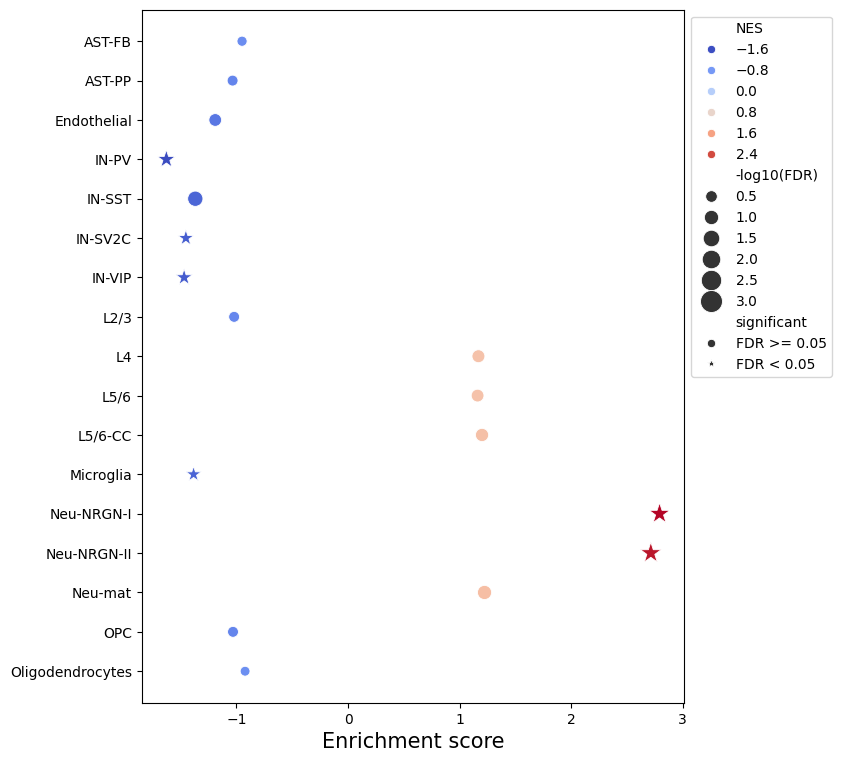

In [21]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [22]:
key = 'wilcoxon'

Run enrichment for genesets

In [23]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:29:56,294 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:57,695 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:29:59,037 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:00,388 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:01,743 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:03,017 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.363527  0.992991  0.443662  0.443662   
0  prerank  human-specific genes -0.337642 -0.790764  0.808081  0.808081   

  FWER p-val  Tag %  Gene %  \
0      0.063   9/59   9.91%   
0   0.808081  18/59  20.59%   

                                          Lead_genes celltype  
0  LHX2;AMZ2;MACF1;ID2;ASAP2;CHST10;NRXN1;ETFB;COTL1   AST-FB  
0  GNAI1;ATP1A3;IGSF21;SCN3B;CX3CL1;PDE1A;NUAK1;G...   AST-PP

Process enrichment results

In [24]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.363527  0.992991  0.443662  0.443662   
0  prerank  human-specific genes -0.337642 -0.790764  0.808081  0.808081   

  FWER p-val  Tag %  Gene %  \
0      0.063   9/59   9.91%   
0   0.808081  18/59  20.59%   

                                          Lead_genes celltype  -log10(FDR)  \
0  LHX2;AMZ2;MACF1;ID2;ASAP2;CHST10;NRXN1;ETFB;COTL1   AST-FB     0.351970   
0  GNAI1;ATP1A3;IGSF21;SCN3B;CX3CL1;PDE1A;NUAK1;G...   AST-PP     0.092008   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

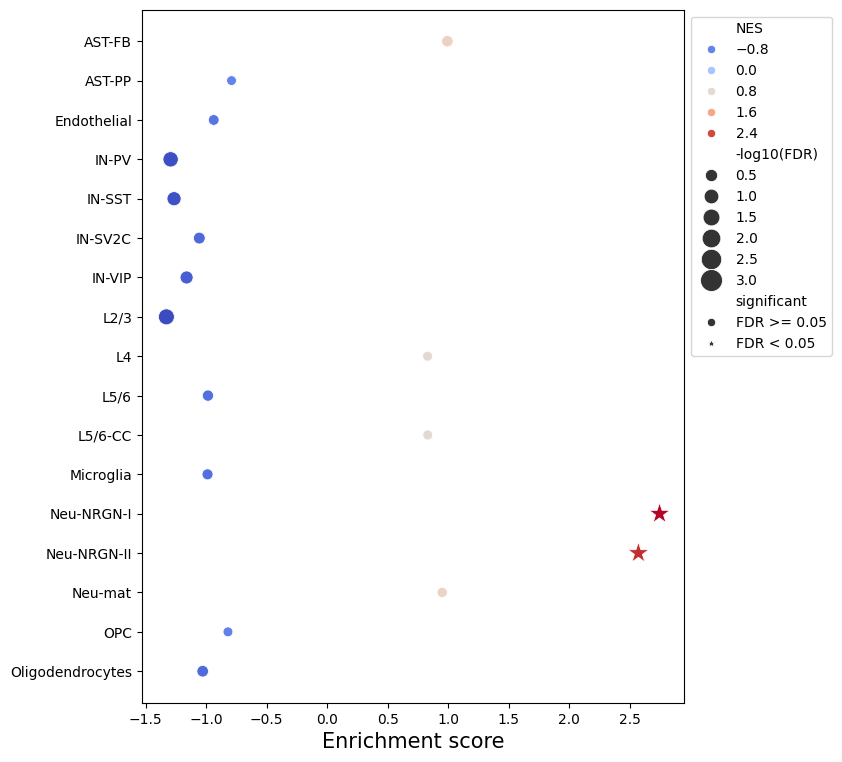

In [25]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [26]:
key = 'logreg'

Run enrichment for genesets

In [27]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:30:20,578 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:21,790 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:25,519 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:26,804 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:28,142 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:29,402 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.348652  1.075045  0.346101  0.346101   
0  prerank  human-specific genes -0.378778 -1.202645  0.160279  0.160279   

  FWER p-val  Tag %  Gene %  \
0      0.253  21/59  20.39%   
0   0.160279  25/59  18.05%   

                                          Lead_genes celltype  
0  MACF1;SYNGAP1;LHX2;NDUFB7;CHST10;ETFB;NDUFB10;...   AST-FB  
0  NUAK1;SYNGAP1;PDE1A;SCN3B;CLSTN1;ATP1A3;GAD1;N...   AST-PP

Process enrichment results

In [28]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.348652  1.075045  0.346101  0.346101   
0  prerank  human-specific genes -0.378778 -1.202645  0.160279  0.160279   

  FWER p-val  Tag %  Gene %  \
0      0.253  21/59  20.39%   
0   0.160279  25/59  18.05%   

                                          Lead_genes celltype  -log10(FDR)  \
0  MACF1;SYNGAP1;LHX2;NDUFB7;CHST10;ETFB;NDUFB10;...   AST-FB     0.459544   
0  NUAK1;SYNGAP1;PDE1A;SCN3B;CLSTN1;ATP1A3;GAD1;N...   AST-PP     0.792423   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

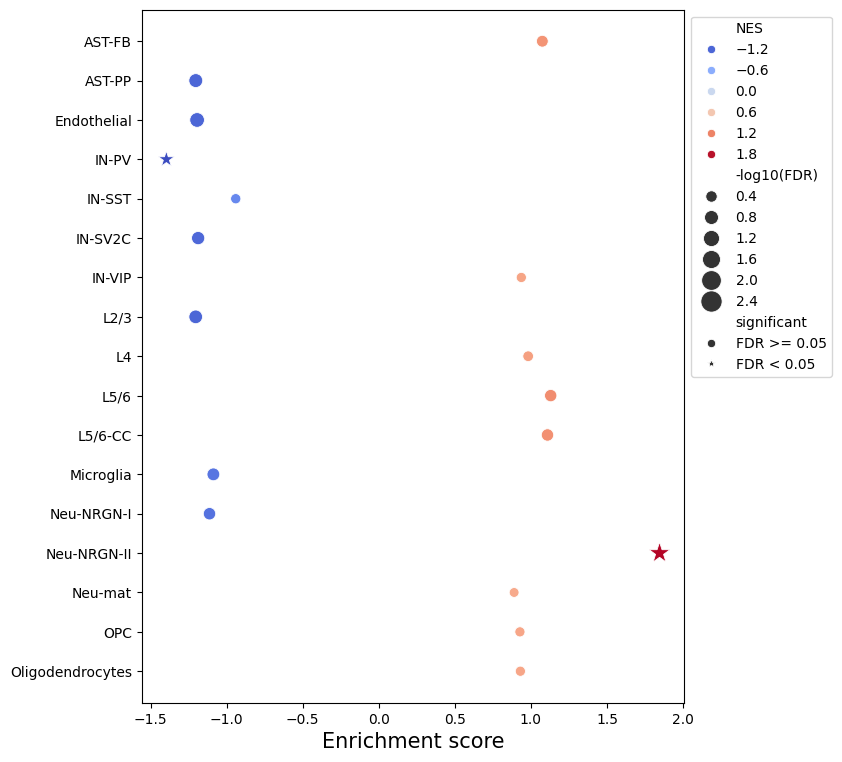

In [29]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [30]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:30:40,937 [WARNING] Duplicated values found in preranked stats: 2.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:40,947 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:30:40,957 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-06-20 18:30:40,958 [INFO] 0001 gene_sets used for further statistical testing.....
2024-06-20 18:30:40,960 [INFO] Start to run GSEA...Might take a while..................
2024-06-20 18:30:42,356 [INFO] Congratulations. GSEApy runs successfully................

2024-06-20 18:30:42,375 [WARNING] Duplicated values found in preranked stats: 1.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:30:42,376 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:30:42,379 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.517599  0.846185  0.734339  0.734339   
0  prerank  human-specific genes   0.53027   0.84603  0.756125  0.756125   

  FWER p-val Tag % Gene %                                         Lead_genes  \
0      0.633  9/60  8.25%  MACF1;LHX2;AMZ2;ID2;NRXN1;ASAP2;CHST10;ETFB;COTL1   
0      0.679  6/60  3.27%                    LHX2;MACF1;NRXN1;ASAP2;ID2;AMZ2   

  celltype  
0   AST-FB  
0   AST-PP

Process enrichment results

In [31]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.517599  0.846185  0.734339  0.734339   
0  prerank  human-specific genes   0.53027   0.84603  0.756125  0.756125   

  FWER p-val Tag % Gene %                                         Lead_genes  \
0      0.633  9/60  8.25%  MACF1;LHX2;AMZ2;ID2;NRXN1;ASAP2;CHST10;ETFB;COTL1   
0      0.679  6/60  3.27%                    LHX2;MACF1;NRXN1;ASAP2;ID2;AMZ2   

  celltype  -log10(FDR) direction  significant  
0   AST-FB     0.133513  enriched  FDR >= 0.05  
0   AST-PP     0.120833  enriched  FDR >= 0.05

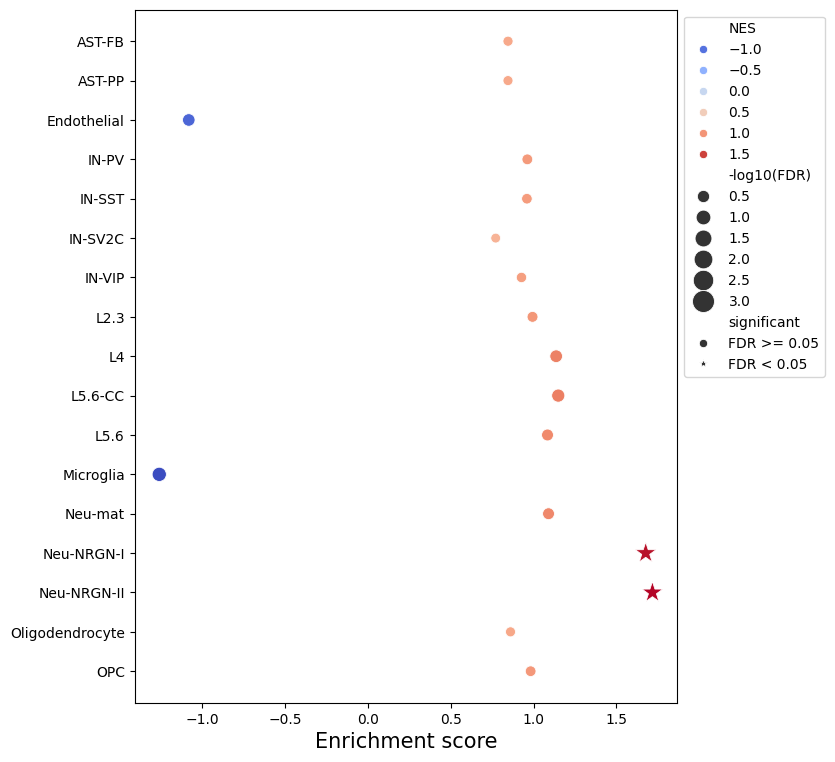

In [32]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [33]:
genes = scaled_adata.var_names.intersection(human_specific_genes)
scaled_adata.obs[f'human_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  \
cell                                                         
AAACCTGGTACGCACC-1_1823_BA24                            18   
AAACGGGCACCAGATT-1_1823_BA24                            18   
AAAGATGAGTCCAGGA-1_1823_BA24                            18   
AAAGATGTCTTGAGGT-1_1823_BA24                            18   
AAAGCAAGTAATCACC-1_1823_BA24                            18   

                              RNA Integrity Number  genes   UMIs  \
cell                                                               
AAACCTGGTACGCACC-1_1823_BA24                   7.0    622    774   
AAACGGGCACCAGATT-1_1823_BA24                   7.0   6926  24042   
AAAGATGAGTCCAGGA-1_1823_BA24                   7.0    624    830   
AAAGATGTCTTGAGGT-1_1823_BA24                   7.0   1192   1771   
AAAGCAAGTAATCACC-1_1823_BA24                   7.0    691    895   

                              RNA mitochondr. percent  RNA ribosomal percent  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24                 2.454780               1.421189   
AAACGGGCACCAGATT-1_1823_BA24                 0.445055               0.428417   
AAAGATGAGTCCAGGA-1_1823_BA24                 0.240964               0.722892   
AAAGATGTCTTGAGGT-1_1823_BA24                 0.225861               1.806889   
AAAGCAAGTAATCACC-1_1823_BA24                 0.558659               0.670391   

                              human_specific_scaled  
cell                                                 
AAACCTGGTACGCACC-1_1823_BA24               0.152301  
AAACGGGCACCAGATT-1_1823_BA24               0.304538  
AAAGATGAGTCCAGGA-1_1823_BA24              -0.096841  
AAAGATGTCTTGAGGT-1_1823_BA24               0.008266  
AAAGCAAGTAATCACC-1_1823_BA24              -0.101924

Vusualize

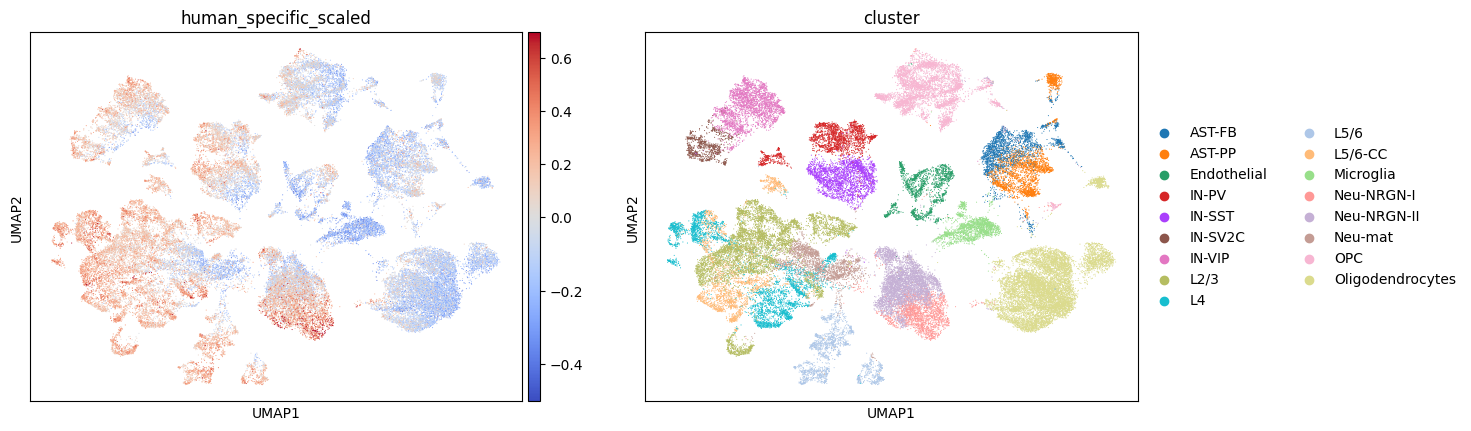

In [34]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.7, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['human_specific_scaled', 'cluster'], cmap=cmap, norm=norm)

## Enrich for HS/AS groups

Create geneset dict

In [35]:
gene_sets = dict()
for label in hs_groups.label.unique():
  gene_sets[label] = hs_groups[hs_groups.label == label].index.to_list()

### T-test

Specify DE test

In [36]:
key = 't-test'

Run enrichment for genesets

In [37]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:31:06,955 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:08,365 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:11,104 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:13,903 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:16,637 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:18,005 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.405037   1.05584  0.366265  0.385986   
1  prerank        age-specific  -0.34895 -0.975201  0.504702       1.0   

  FWER p-val Tag %  Gene %                                 Lead_genes celltype  
0      0.499  3/15   4.97%                             MACF1;LHX2;ID2   AST-FB  
1   0.785567  7/26  11.94%  PDE1A;GNAI1;ATP1A3;GAD1;CX3CL1;NRXN2;PPA1   AST-FB

Process enrichment results

In [38]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.405037   1.05584  0.366265  0.385986   
1  prerank        age-specific  -0.34895 -0.975201  0.504702       1.0   

  FWER p-val Tag %  Gene %                                 Lead_genes  \
0      0.499  3/15   4.97%                             MACF1;LHX2;ID2   
1   0.785567  7/26  11.94%  PDE1A;GNAI1;ATP1A3;GAD1;CX3CL1;NRXN2;PPA1   

  celltype  -log10(FDR) direction  significant  
0   AST-FB     0.412304  enriched  FDR >= 0.05  
1   AST-FB    -0.000434  depleted  FDR >= 0.05

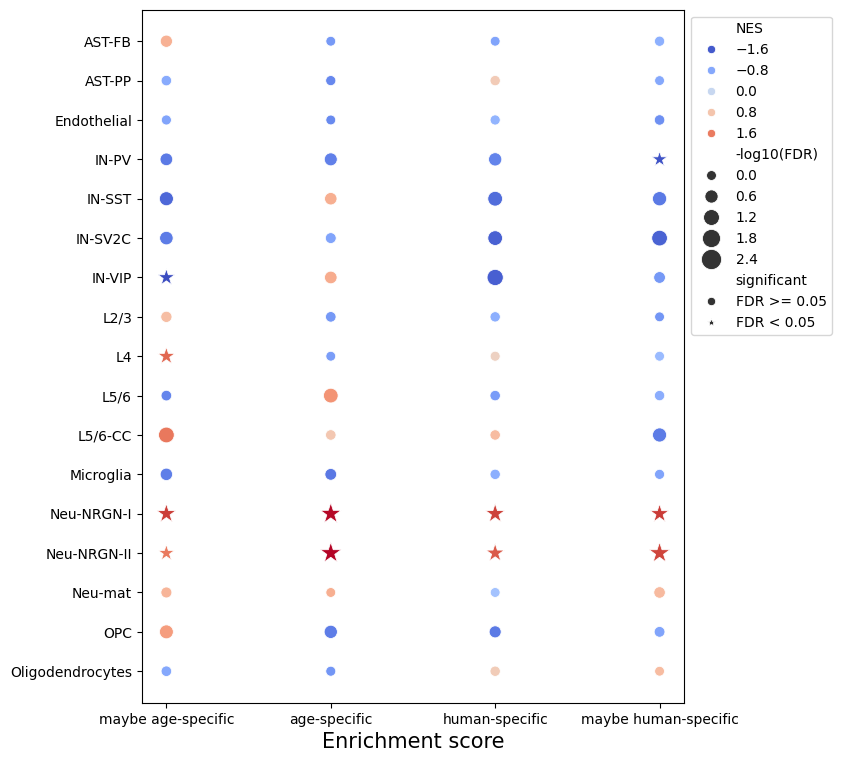

In [39]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

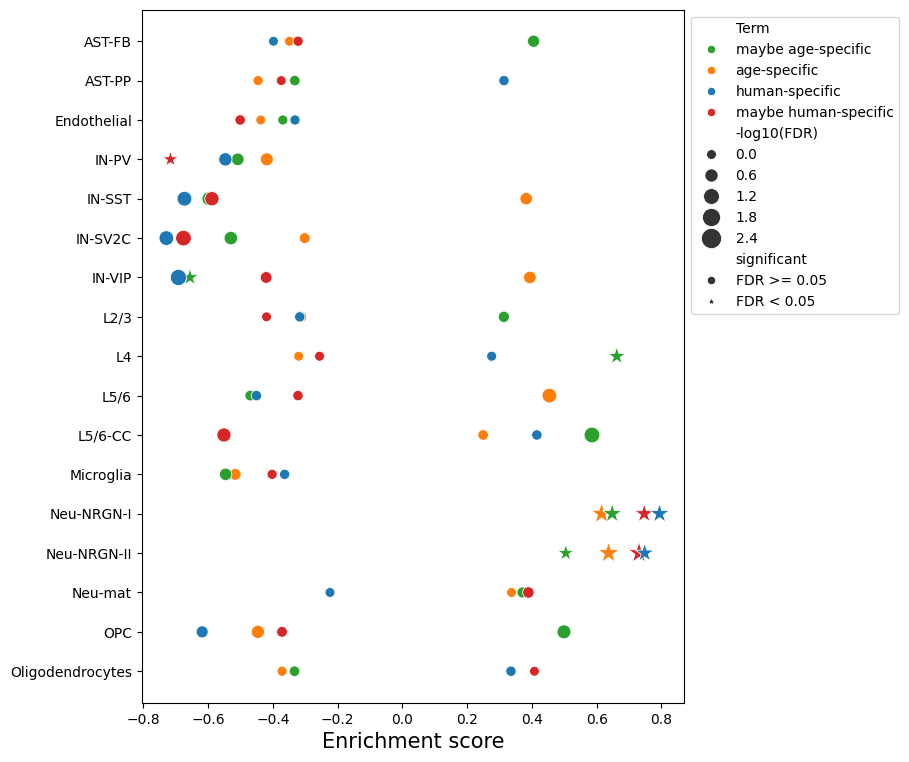

In [40]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

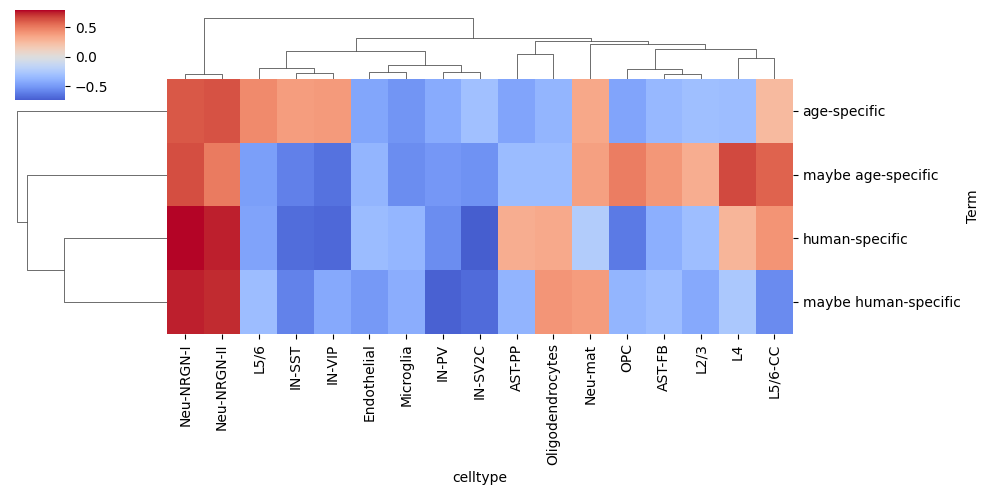

In [41]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

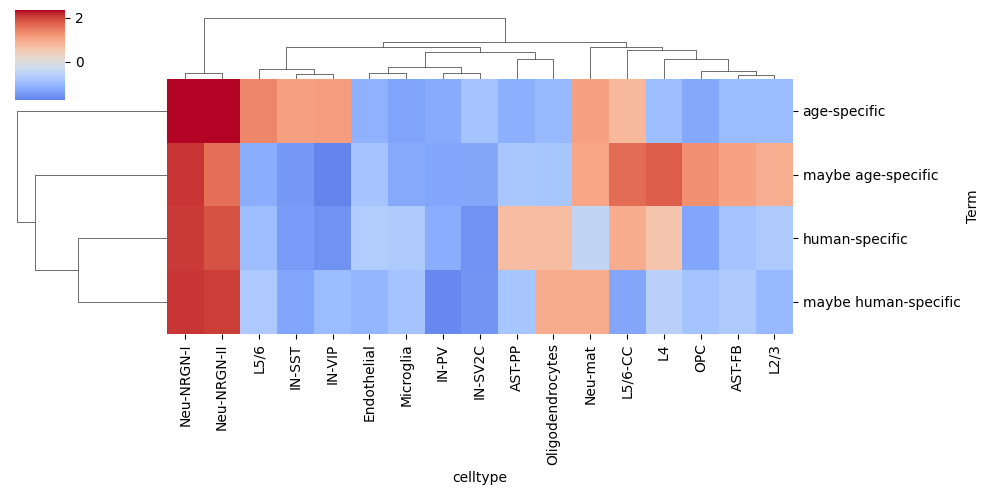

In [42]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Wilcoxon

Specify DE test

In [43]:
key = 'wilcoxon'

Run enrichment for genesets

In [44]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:31:31,715 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:33,522 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:35,115 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:36,620 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:38,090 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:31:39,592 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.561069  1.113142  0.319079       1.0   
1  prerank      human-specific  0.516144  0.912121  0.596306  0.889099   

  FWER p-val Tag % Gene %      Lead_genes celltype  
0      0.391  3/15  4.14%  LHX2;MACF1;ID2   AST-FB  
1       0.58   1/8  2.46%            AMZ2   AST-FB

Process enrichment results

In [45]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.561069  1.113142  0.319079       1.0   
1  prerank      human-specific  0.516144  0.912121  0.596306  0.889099   

  FWER p-val Tag % Gene %      Lead_genes celltype  -log10(FDR) direction  \
0      0.391  3/15  4.14%  LHX2;MACF1;ID2   AST-FB    -0.000434  enriched   
1       0.58   1/8  2.46%            AMZ2   AST-FB     0.050562  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

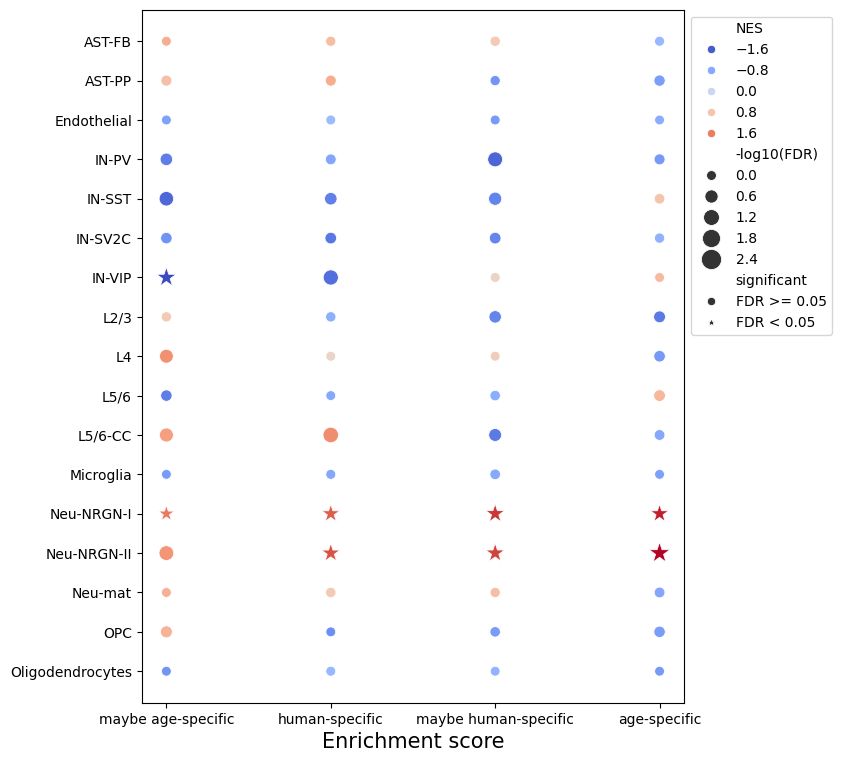

In [46]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

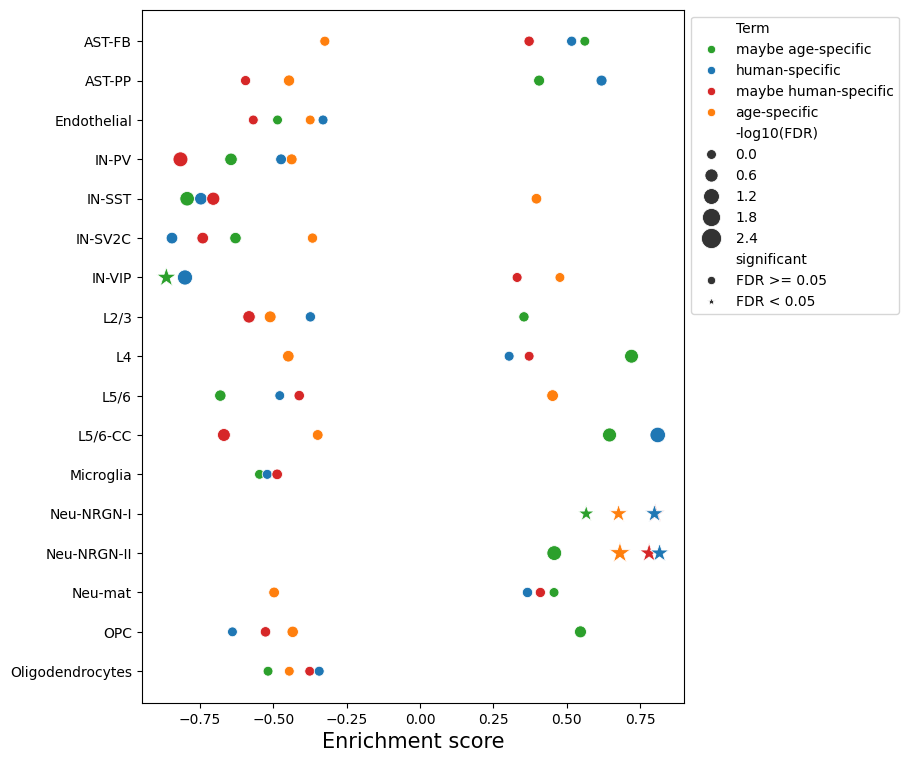

In [47]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

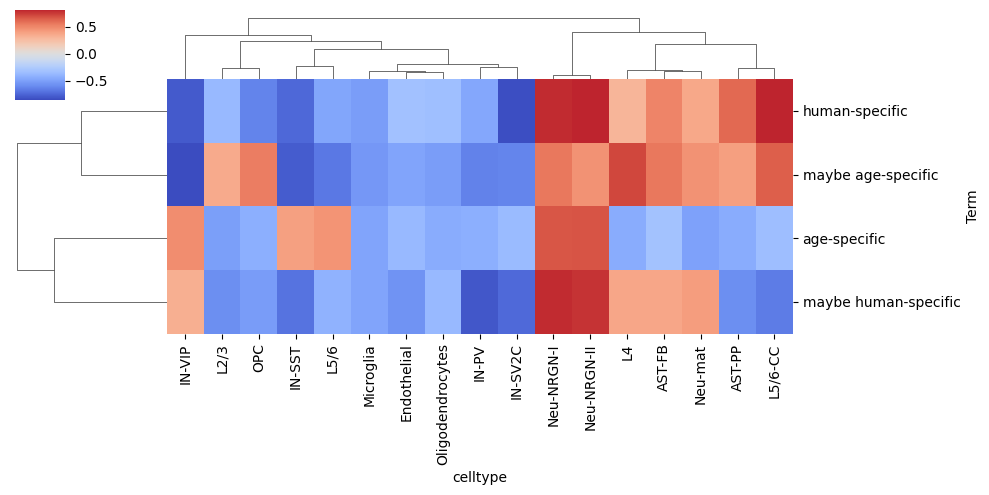

In [48]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

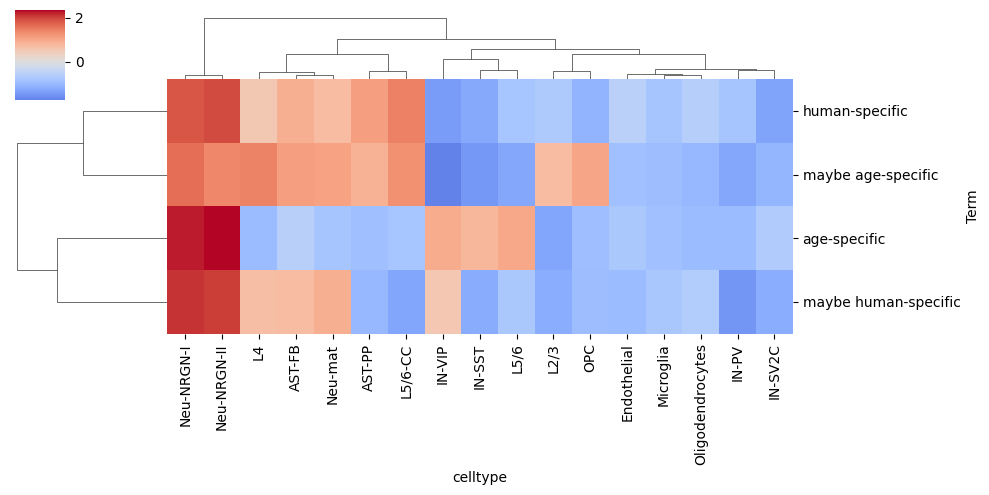

In [49]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Logreg

Specify DE test

In [50]:
key = 'logreg'

Run enrichment for genesets

In [51]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:31:59,799 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:01,072 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:05,070 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:06,450 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:07,740 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:09,123 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe human-specific  0.536589  1.138005  0.331034  0.933775   
1  prerank        human-specific -0.526078 -1.124494  0.328798  0.304924   

  FWER p-val Tag %  Gene %                        Lead_genes celltype  
0      0.558  5/10  19.42%  NDUFB7;CHST10;KIF21B;NUAK1;SCN3B   AST-FB  
1   0.440909   2/8   8.19%                      ASAH1;IGFBP6   AST-FB

Process enrichment results

In [52]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe human-specific  0.536589  1.138005  0.331034  0.933775   
1  prerank        human-specific -0.526078 -1.124494  0.328798  0.304924   

  FWER p-val Tag %  Gene %                        Lead_genes celltype  \
0      0.558  5/10  19.42%  NDUFB7;CHST10;KIF21B;NUAK1;SCN3B   AST-FB   
1   0.440909   2/8   8.19%                      ASAH1;IGFBP6   AST-FB   

   -log10(FDR) direction  significant  
0     0.029293  enriched  FDR >= 0.05  
1     0.514386  depleted  FDR >= 0.05

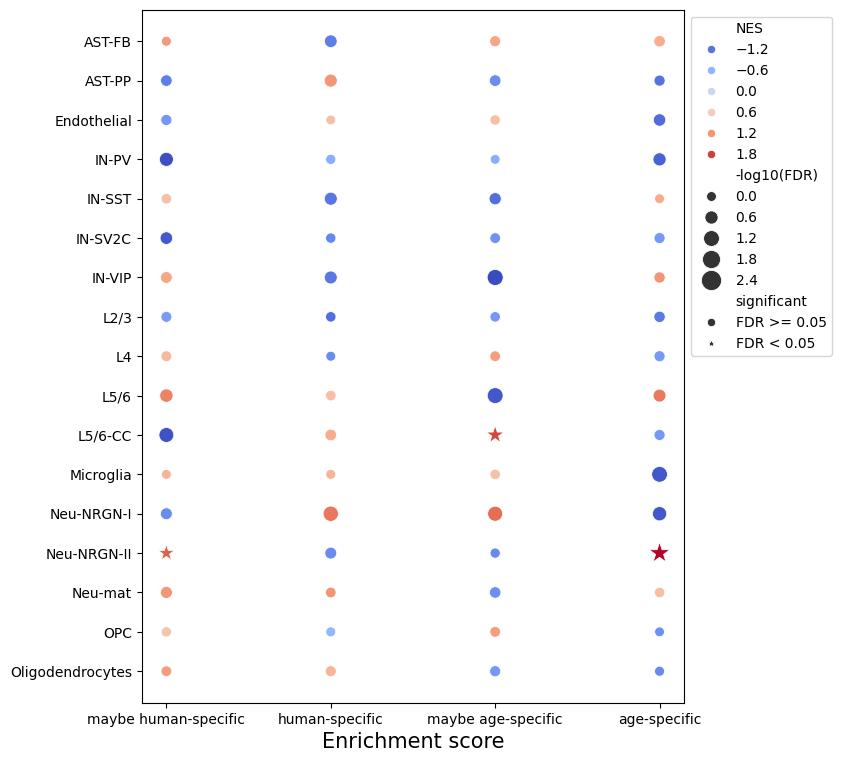

In [53]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

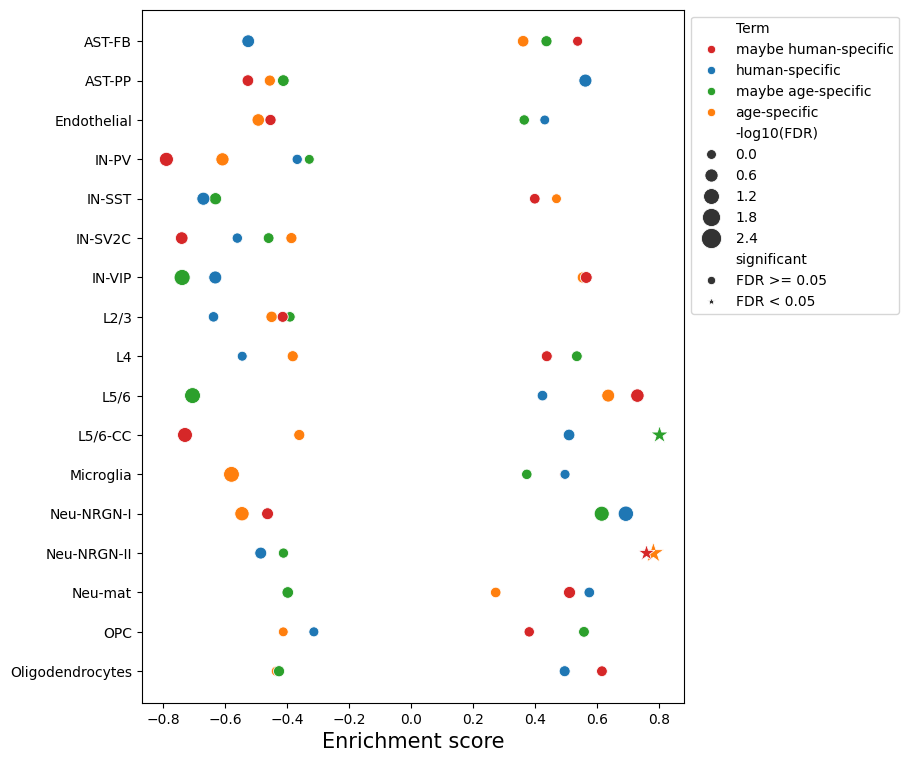

In [54]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

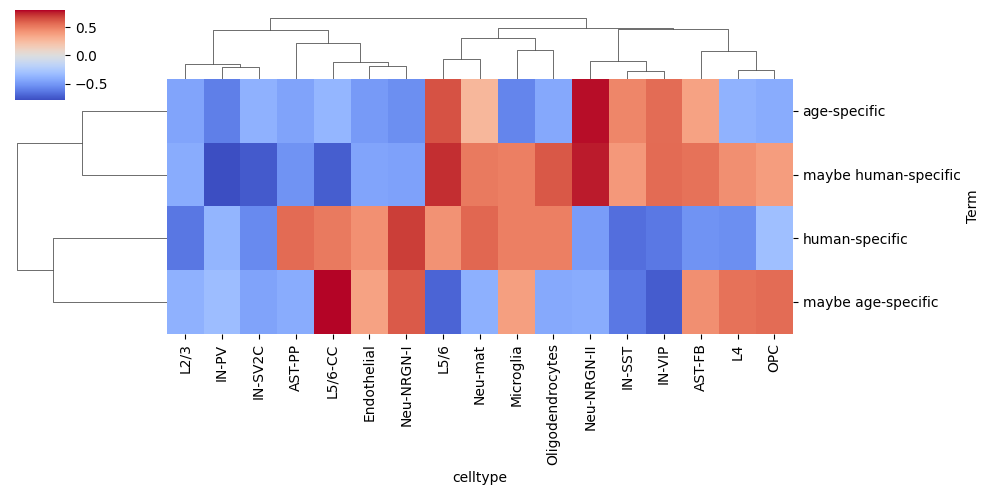

In [55]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

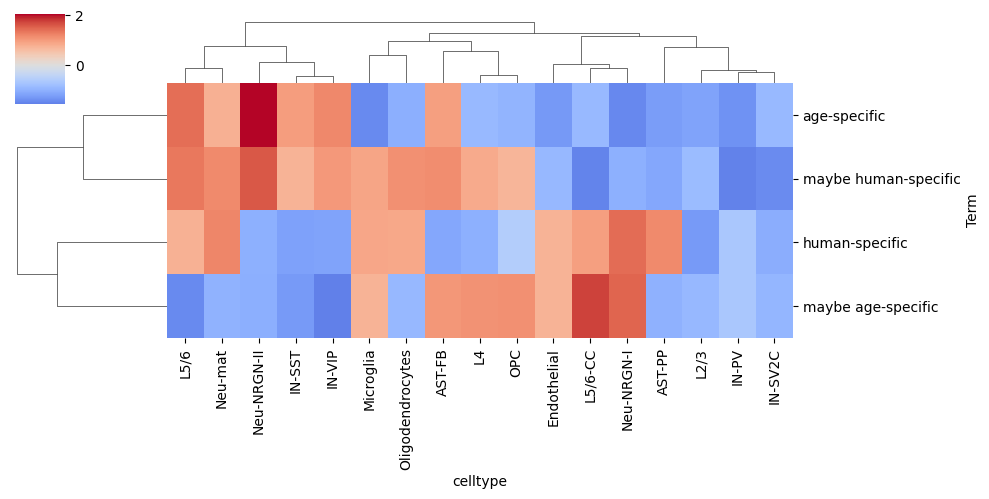

In [56]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### EdgeR

Run enrichment for genesets

In [57]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:32:23,568 [WARNING] Duplicated values found in preranked stats: 2.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:23,569 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:32:23,573 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-06-20 18:32:23,575 [INFO] 0004 gene_sets used for further statistical testing.....
2024-06-20 18:32:23,576 [INFO] Start to run GSEA...Might take a while..................
2024-06-20 18:32:25,099 [INFO] Congratulations. GSEApy runs successfully................

2024-06-20 18:32:25,115 [WARNING] Duplicated values found in preranked stats: 1.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:25,117 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:32:25,120 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.737822  1.107568  0.416933  0.817785   
1  prerank      human-specific  0.661932  0.930931   0.62167  0.614133   

  FWER p-val Tag % Gene %      Lead_genes celltype  
0      0.705  3/15  3.01%  MACF1;LHX2;ID2   AST-FB  
1      0.864   1/8  2.83%            AMZ2   AST-FB

Process enrichment results

In [58]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.737822  1.107568  0.416933  0.817785   
1  prerank      human-specific  0.661932  0.930931   0.62167  0.614133   

  FWER p-val Tag % Gene %      Lead_genes celltype  -log10(FDR) direction  \
0      0.705  3/15  3.01%  MACF1;LHX2;ID2   AST-FB     0.086830  enriched   
1      0.864   1/8  2.83%            AMZ2   AST-FB     0.211031  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

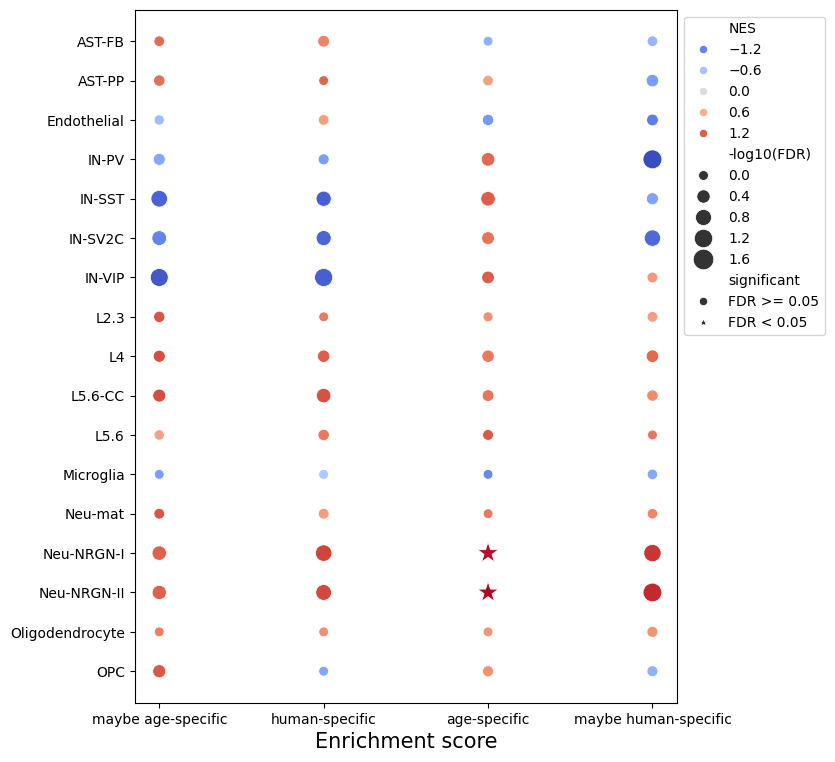

In [59]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

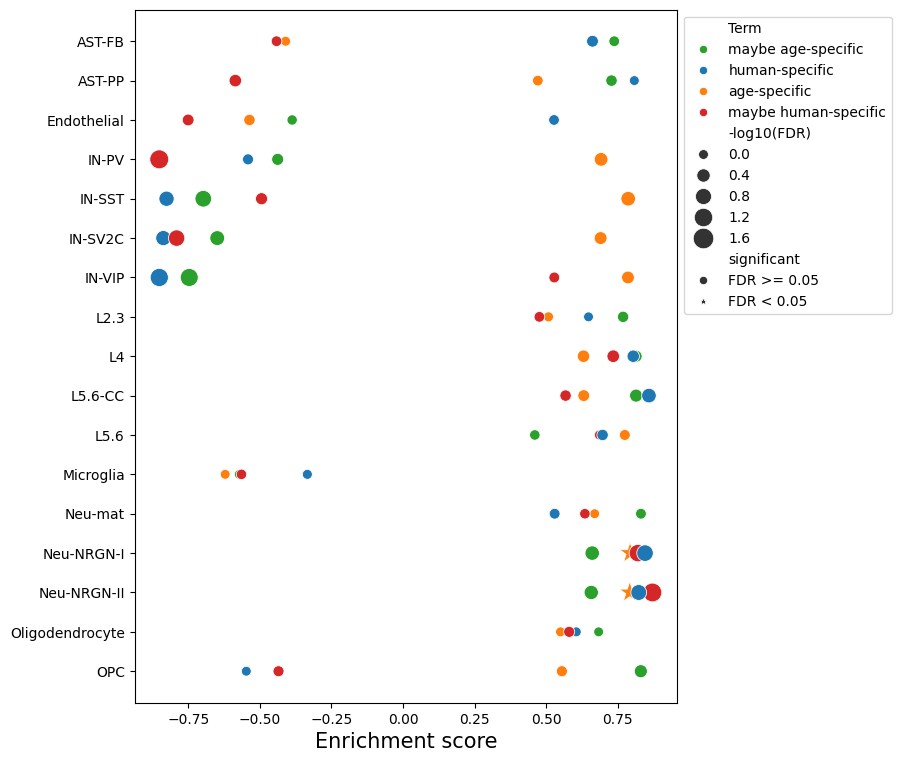

In [60]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

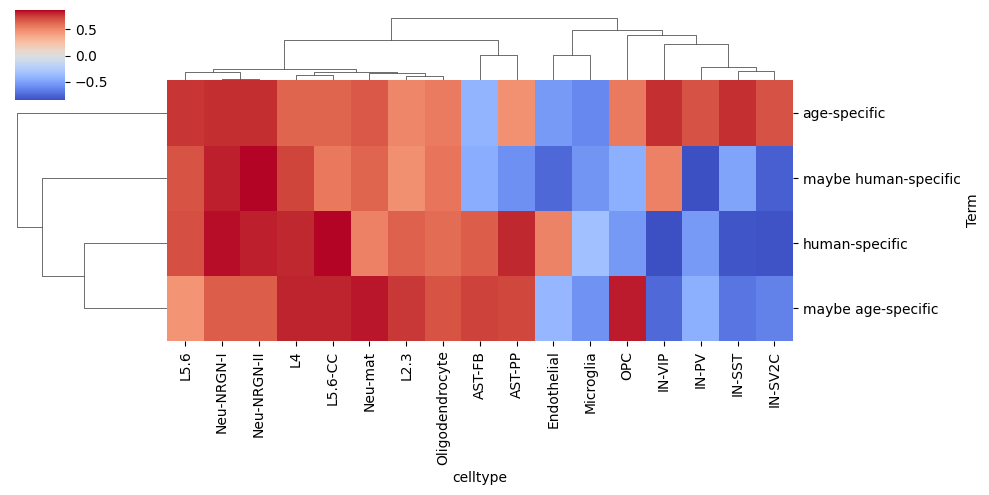

In [61]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

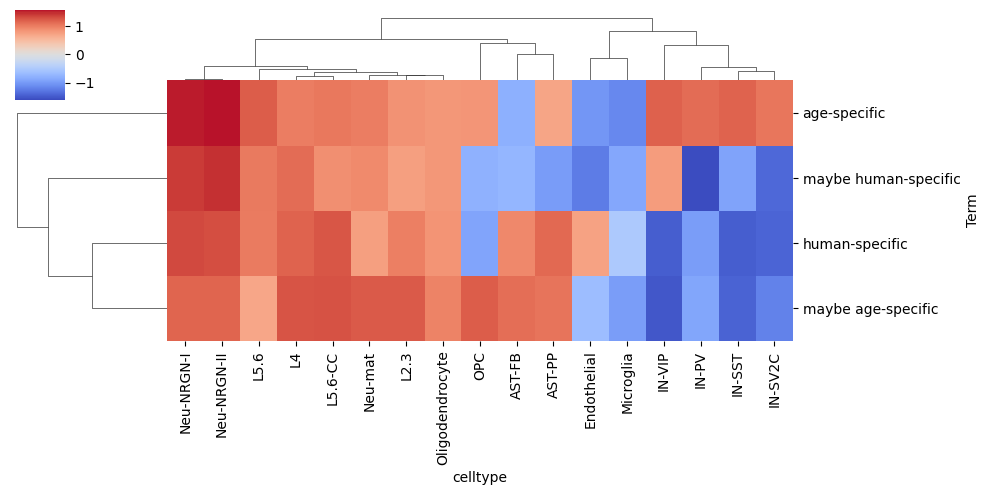

In [62]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Gene visualization

Calculate average normalized expression

In [63]:
for cluster in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cluster])
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  \
cell                                                         
AAACCTGGTACGCACC-1_1823_BA24                            18   
AAACGGGCACCAGATT-1_1823_BA24                            18   
AAAGATGAGTCCAGGA-1_1823_BA24                            18   
AAAGATGTCTTGAGGT-1_1823_BA24                            18   
AAAGCAAGTAATCACC-1_1823_BA24                            18   

                              RNA Integrity Number  genes   UMIs  \
cell                                                               
AAACCTGGTACGCACC-1_1823_BA24                   7.0    622    774   
AAACGGGCACCAGATT-1_1823_BA24                   7.0   6926  24042   
AAAGATGAGTCCAGGA-1_1823_BA24                   7.0    624    830   
AAAGATGTCTTGAGGT-1_1823_BA24                   7.0   1192   1771   
AAAGCAAGTAATCACC-1_1823_BA24                   7.0    691    895   

                              RNA mitochondr. percent  RNA ribosomal percent  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24                 2.454780               1.421189   
AAACGGGCACCAGATT-1_1823_BA24                 0.445055               0.428417   
AAAGATGAGTCCAGGA-1_1823_BA24                 0.240964               0.722892   
AAAGATGTCTTGAGGT-1_1823_BA24                 0.225861               1.806889   
AAAGCAAGTAATCACC-1_1823_BA24                 0.558659               0.670391   

                              human_specific_scaled  age-specific_scaled  \
cell                                                                       
AAACCTGGTACGCACC-1_1823_BA24               0.152301             0.080602   
AAACGGGCACCAGATT-1_1823_BA24               0.304538             0.336339   
AAAGATGAGTCCAGGA-1_1823_BA24              -0.096841            -0.208213   
AAAGATGTCTTGAGGT-1_1823_BA24               0.008266             0.051992   
AAAGCAAGTAATCACC-1_1823_BA24              -0.101924            -0.324373   

                              maybe age-specific_scaled  \
cell                                                      
AAACCTGGTACGCACC-1_1823_BA24                   0.073885   
AAACGGGCACCAGATT-1_1823_BA24                   0.302790   
AAAGATGAGTCCAGGA-1_1823_BA24                  -0.117305   
AAAGATGTCTTGAGGT-1_1823_BA24                  -0.025779   
AAAGCAAGTAATCACC-1_1823_BA24                  -0.093362   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.755120   
AAACGGGCACCAGATT-1_1823_BA24                     0.239773   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.311614   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.343143   
AAAGCAAGTAATCACC-1_1823_BA24                     0.130890   

                              human-specific_scaled  
cell                                                 
AAACCTGGTACGCACC-1_1823_BA24          

Vusualize

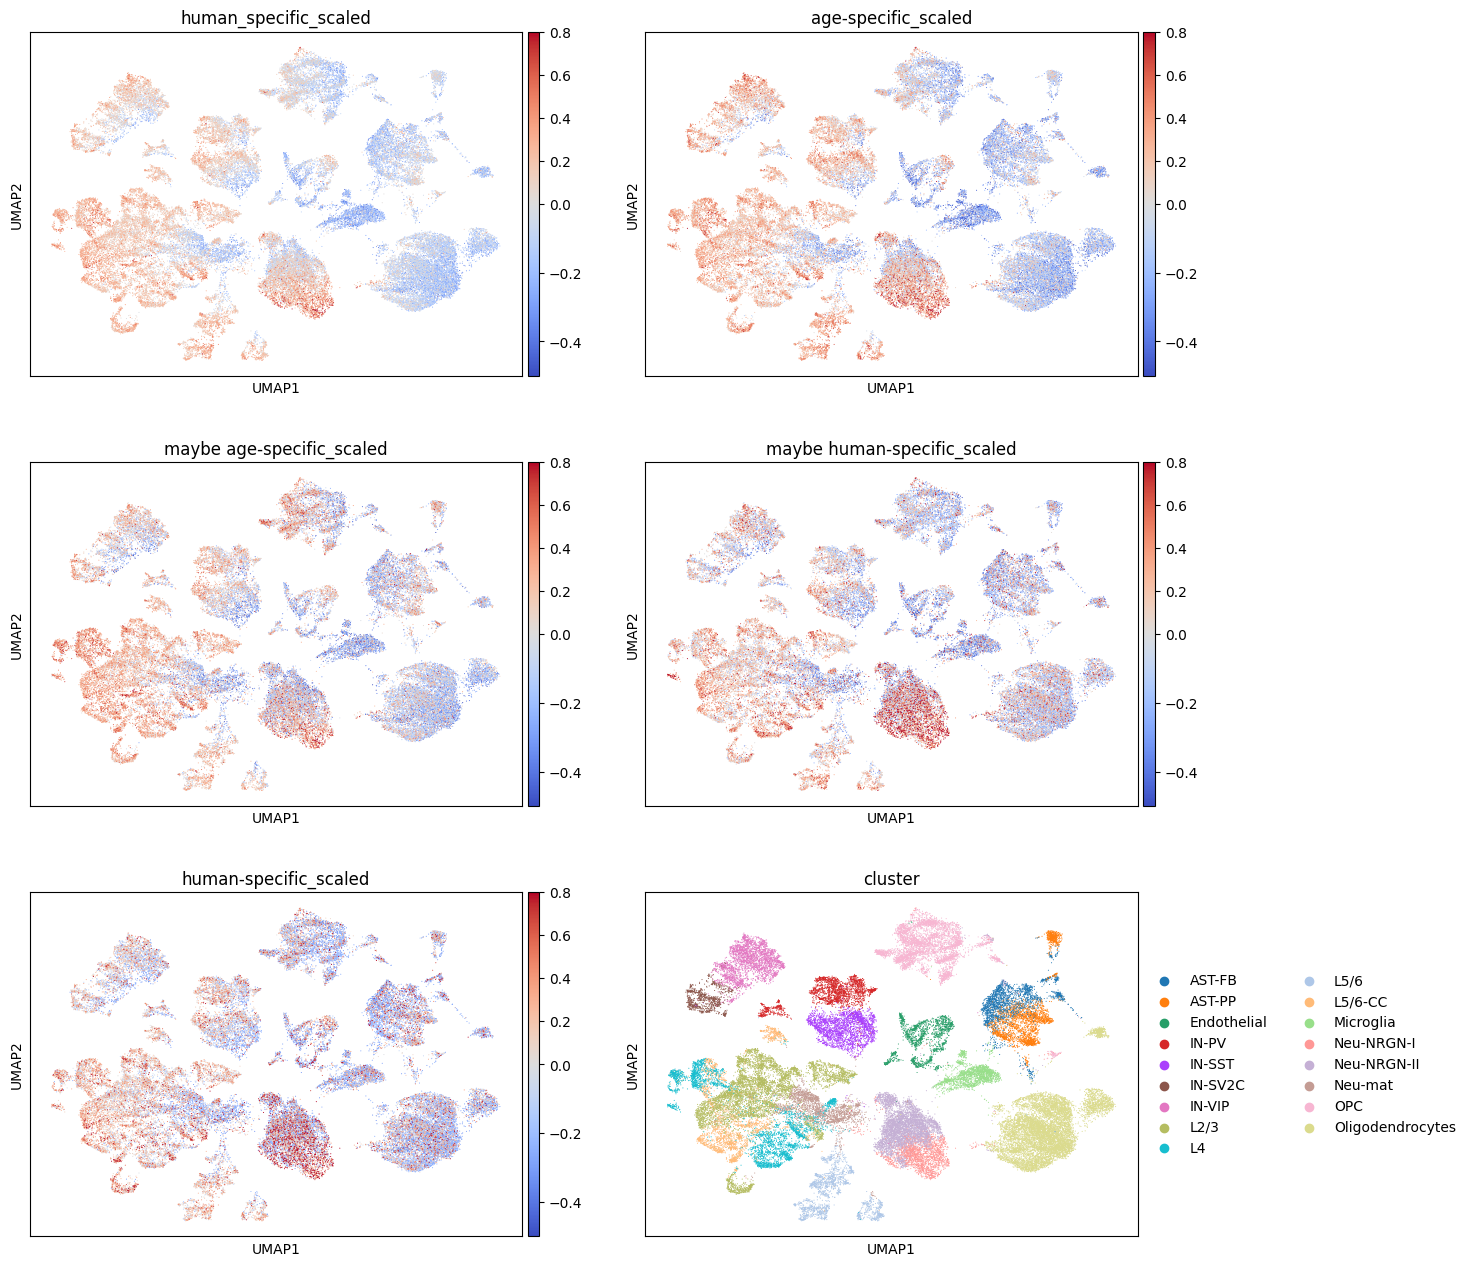

In [64]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.8, vmin=-0.5)
color = [
    'human_specific_scaled', 
    'age-specific_scaled', 
    'maybe age-specific_scaled', 
    'maybe human-specific_scaled', 
    'human-specific_scaled', 
    'cluster'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

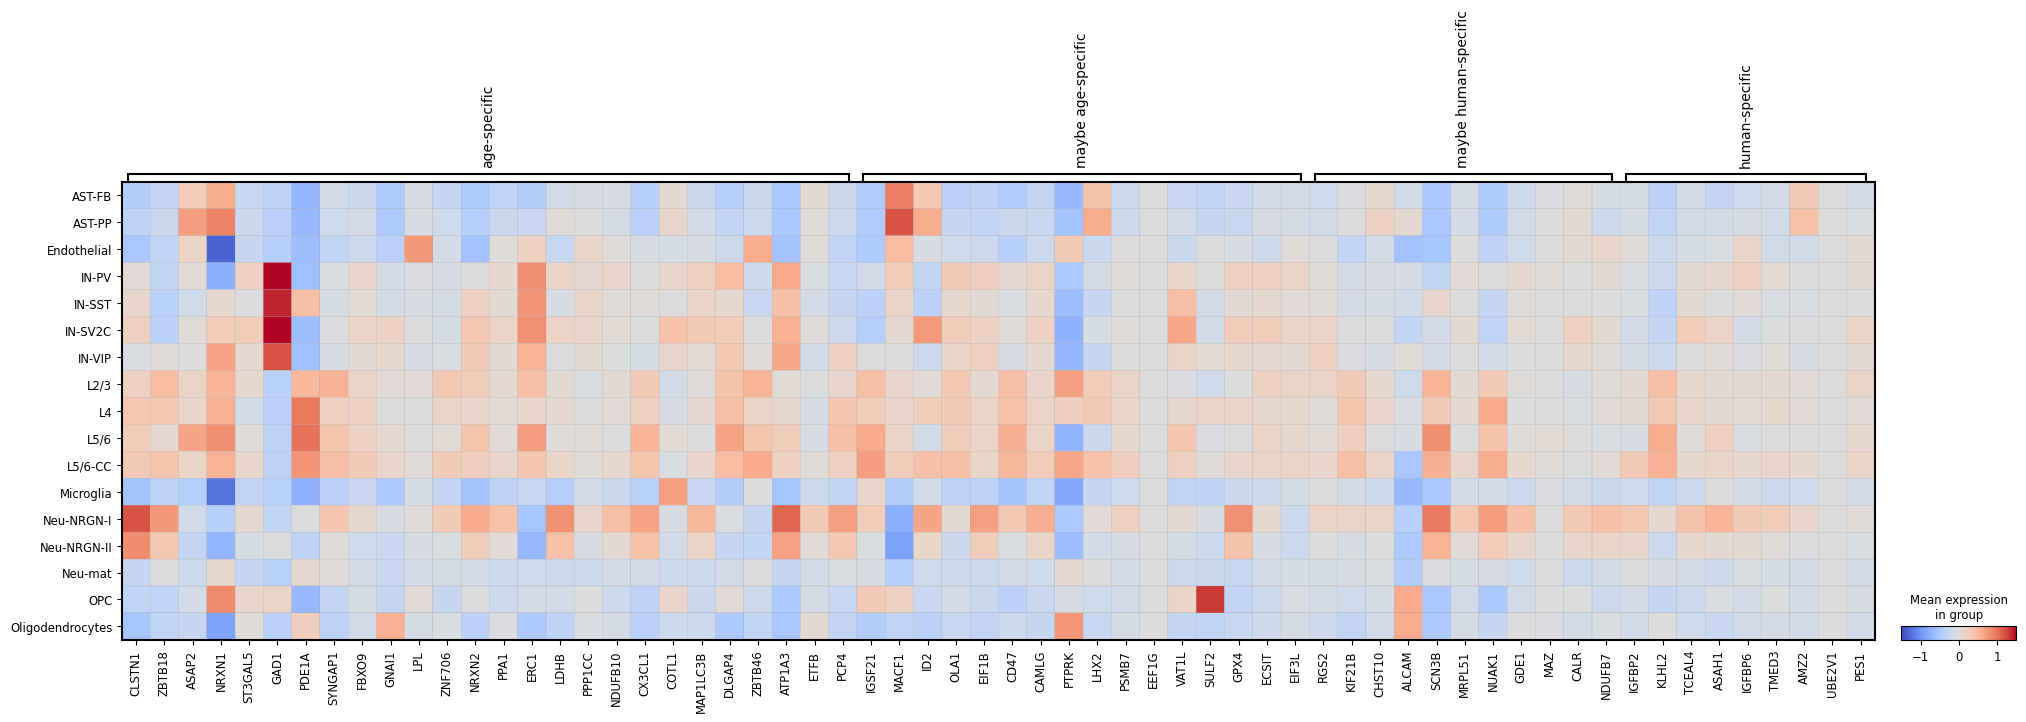

In [65]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

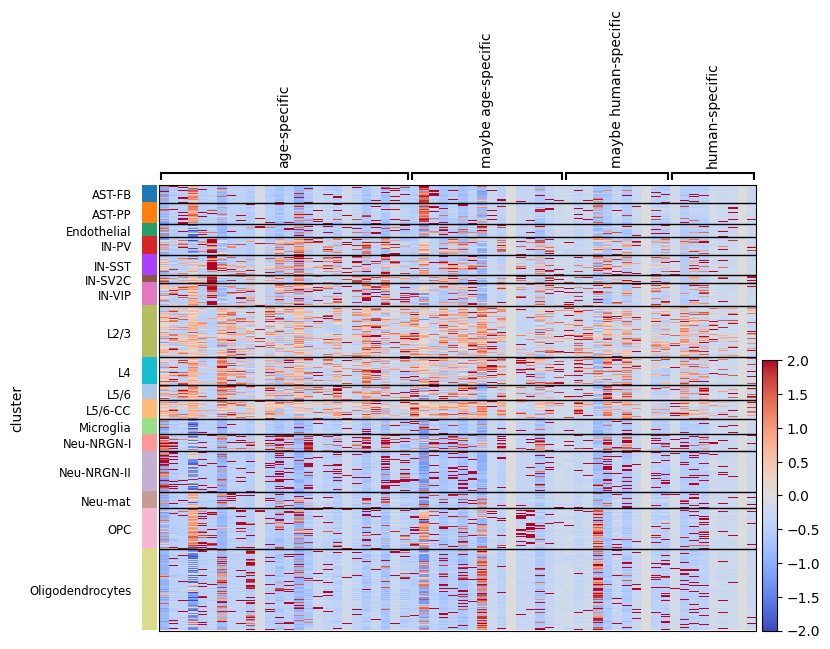

In [66]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

## Enrich for clusters

In [67]:
gene_sets = dict()
for label in cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = cluster_groups[cluster_groups.label == label].index.to_list()

### T-test

Specify DE test

In [68]:
key = 't-test'

Run enrichment for genesets

In [69]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:32:55,442 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:32:56,982 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:00,135 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:03,120 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:05,959 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:07,405 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.759113 -1.546673  0.022375  0.067912   0.078313   6/7   
1  prerank  cluster5  0.568155  1.269259  0.192857  0.585158      0.388   3/8   

   Gene %                          Lead_genes celltype  
0  23.74%  NUAK1;GNAI1;CX3CL1;PPA1;KLHL2;OLA1   AST-FB  
1   6.55%                    LHX2;CHST10;ETFB   AST-FB

Process enrichment results

In [70]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.759113 -1.546673  0.022375  0.067912   0.078313   6/7   
1  prerank  cluster5  0.568155  1.269259  0.192857  0.585158      0.388   3/8   

   Gene %                          Lead_genes celltype  -log10(FDR) direction  \
0  23.74%  NUAK1;GNAI1;CX3CL1;PPA1;KLHL2;OLA1   AST-FB     1.161707  depleted   
1   6.55%                    LHX2;CHST10;ETFB   AST-FB     0.231985  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

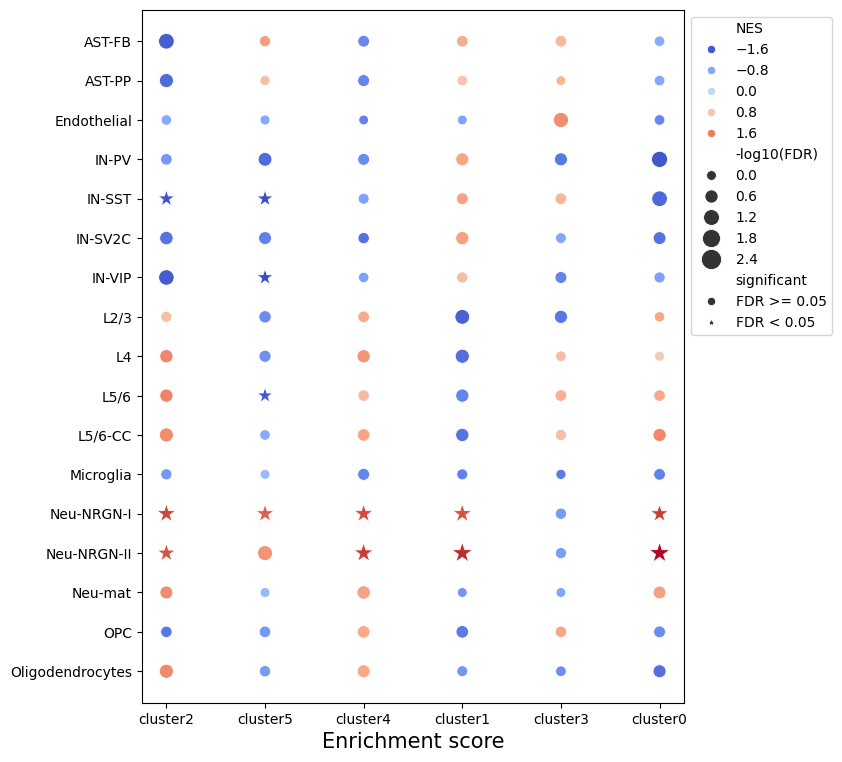

In [71]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_17896\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


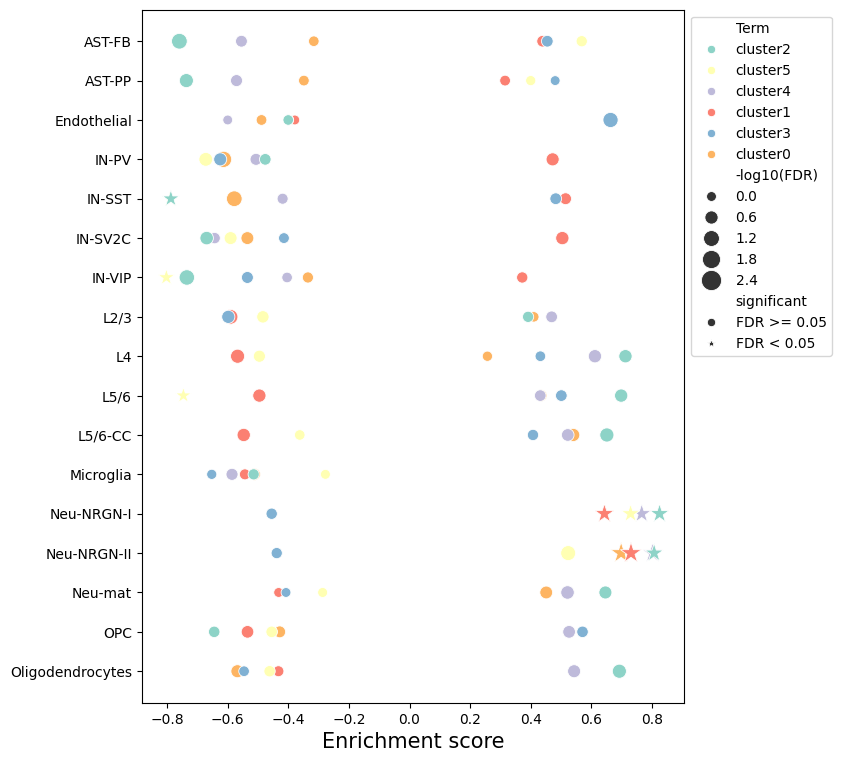

In [72]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

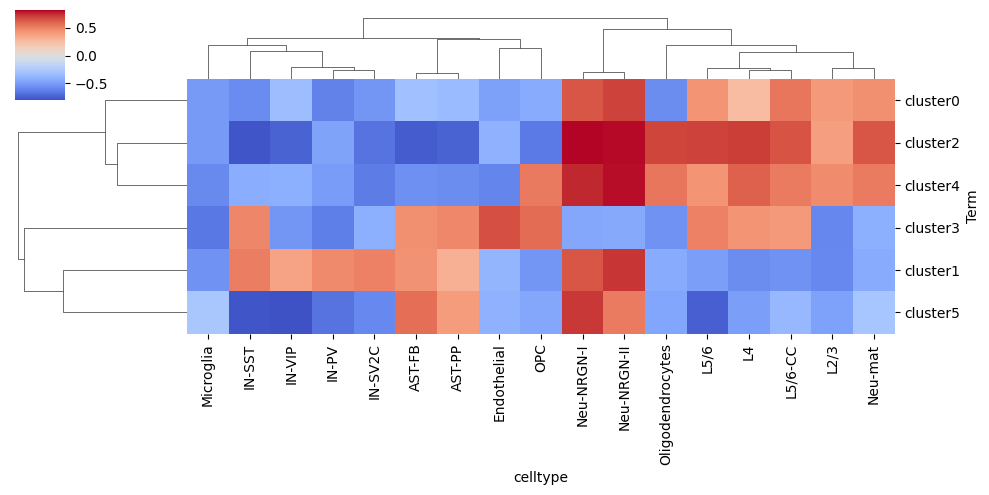

In [73]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

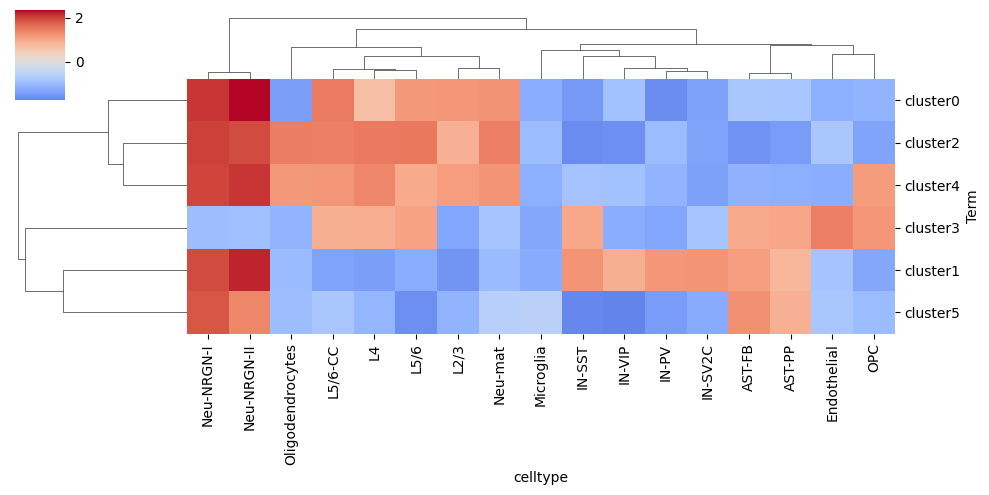

In [74]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Wilcoxon

Specify DE test

In [75]:
key = 'wilcoxon'

Run enrichment for genesets

In [76]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:33:22,419 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:23,992 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:25,405 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:26,944 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:28,557 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:30,062 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster1  0.752594   1.50123  0.017857  0.097079       0.07  2/13   
1  prerank  cluster5  0.694161  1.226386  0.263566  0.358652      0.432   4/8   

  Gene %              Lead_genes celltype  
0  5.10%              AMZ2;ASAP2   AST-FB  
1  9.91%  LHX2;CHST10;ETFB;COTL1   AST-FB

Process enrichment results

In [77]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster1  0.752594   1.50123  0.017857  0.097079       0.07  2/13   
1  prerank  cluster5  0.694161  1.226386  0.263566  0.358652      0.432   4/8   

  Gene %              Lead_genes celltype  -log10(FDR) direction  significant  
0  5.10%              AMZ2;ASAP2   AST-FB     1.008426  enriched  FDR >= 0.05  
1  9.91%  LHX2;CHST10;ETFB;COTL1   AST-FB     0.444118  enriched  FDR >= 0.05

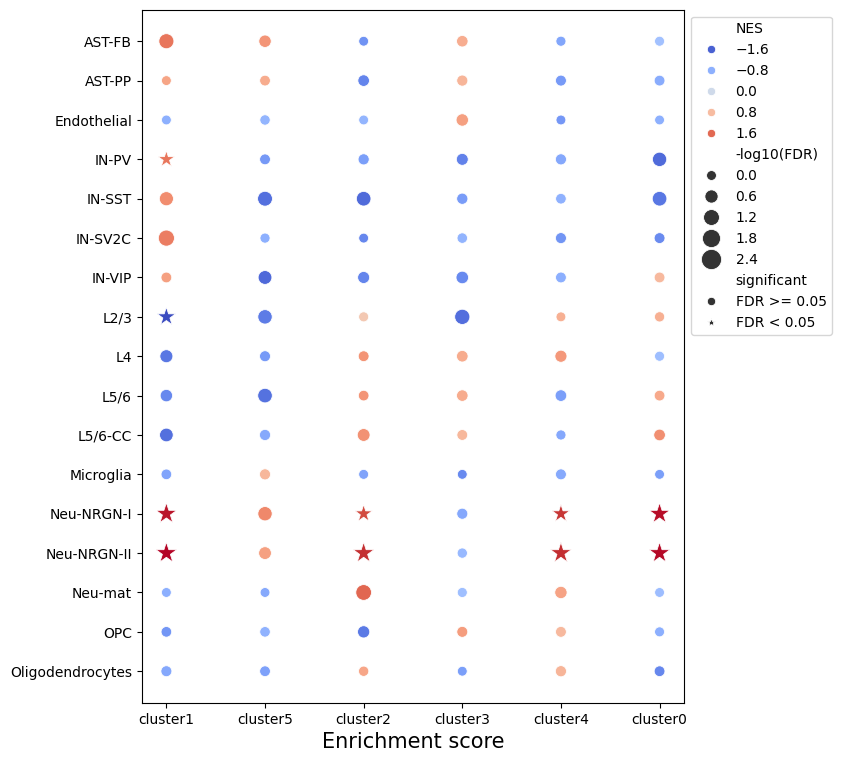

In [78]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_17896\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


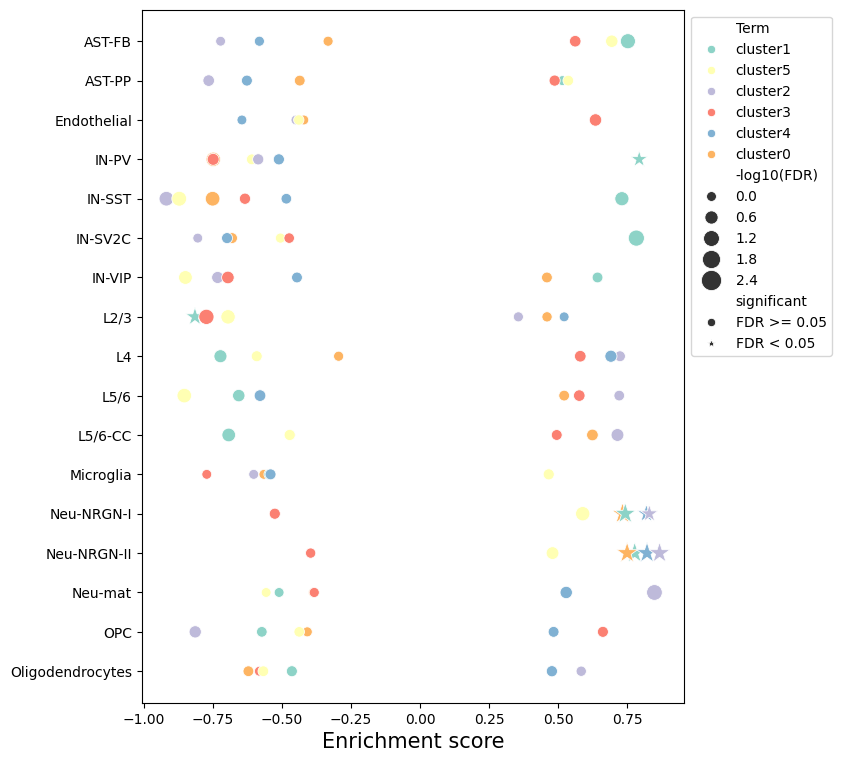

In [79]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

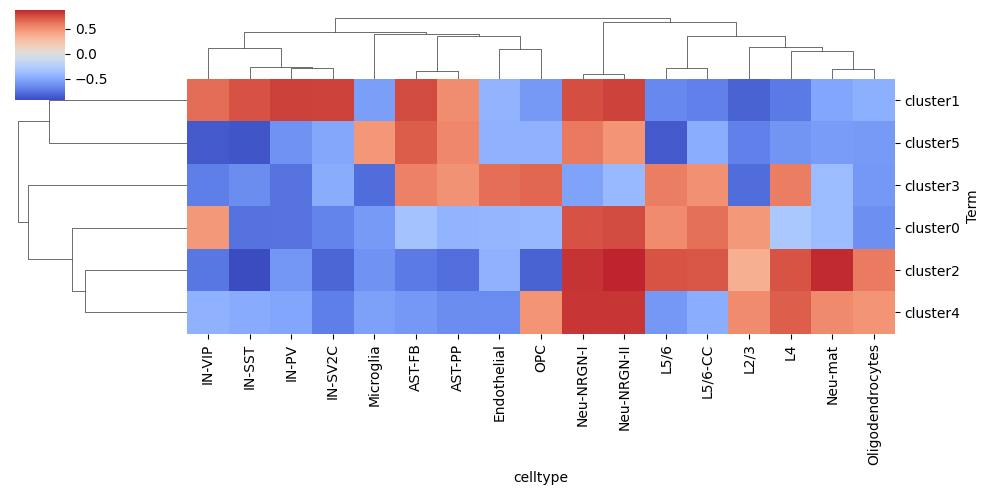

In [80]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

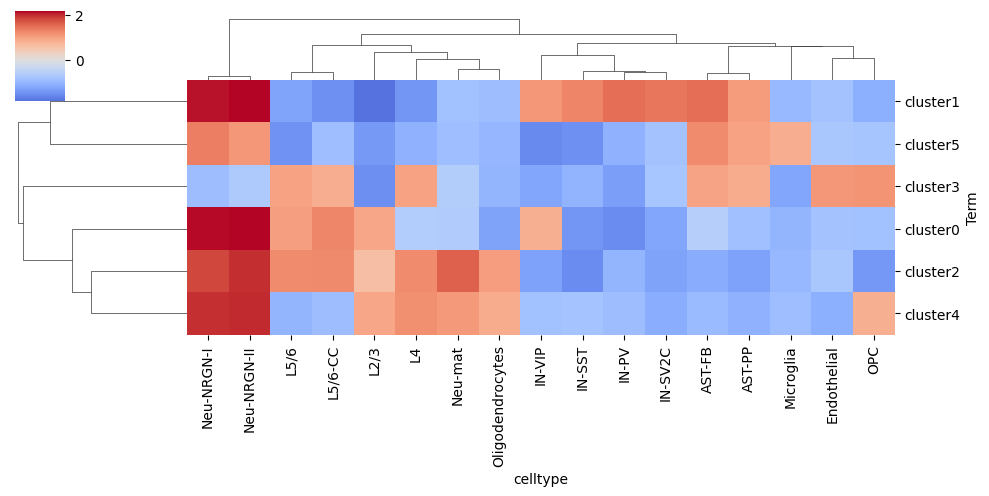

In [81]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Logreg

Specify DE test

In [82]:
key = 'logreg'

Run enrichment for genesets

In [83]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:33:51,172 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:52,594 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:56,831 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:58,251 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:33:59,687 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:01,137 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5   0.59829  1.213103  0.237347  0.987583       0.61   3/8   
1  prerank  cluster1  0.526581  1.202288  0.244628  0.519203       0.63  6/13   

   Gene %                             Lead_genes celltype  
0   5.32%                       LHX2;CHST10;ETFB   AST-FB  
1  19.45%  NDUFB7;NDUFB10;GAD1;TCEAL4;PSMB7;AMZ2   AST-FB

Process enrichment results

In [84]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5   0.59829  1.213103  0.237347  0.987583       0.61   3/8   
1  prerank  cluster1  0.526581  1.202288  0.244628  0.519203       0.63  6/13   

   Gene %                             Lead_genes celltype  -log10(FDR)  \
0   5.32%                       LHX2;CHST10;ETFB   AST-FB     0.004987   
1  19.45%  NDUFB7;NDUFB10;GAD1;TCEAL4;PSMB7;AMZ2   AST-FB     0.283827   

  direction  significant  
0  enriched  FDR >= 0.05  
1  enriched  FDR >= 0.05

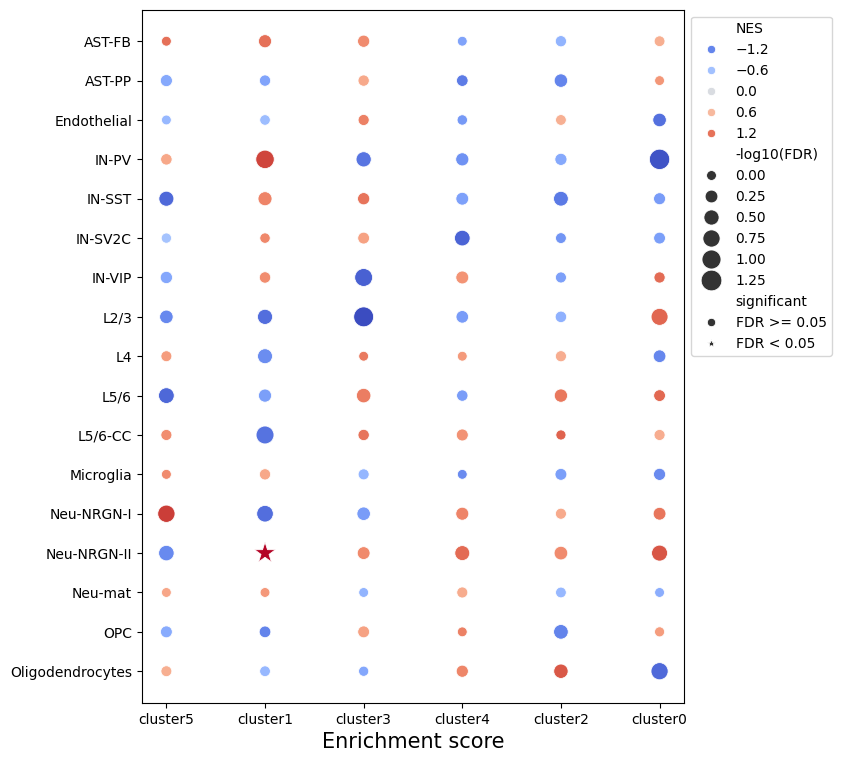

In [85]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_17896\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


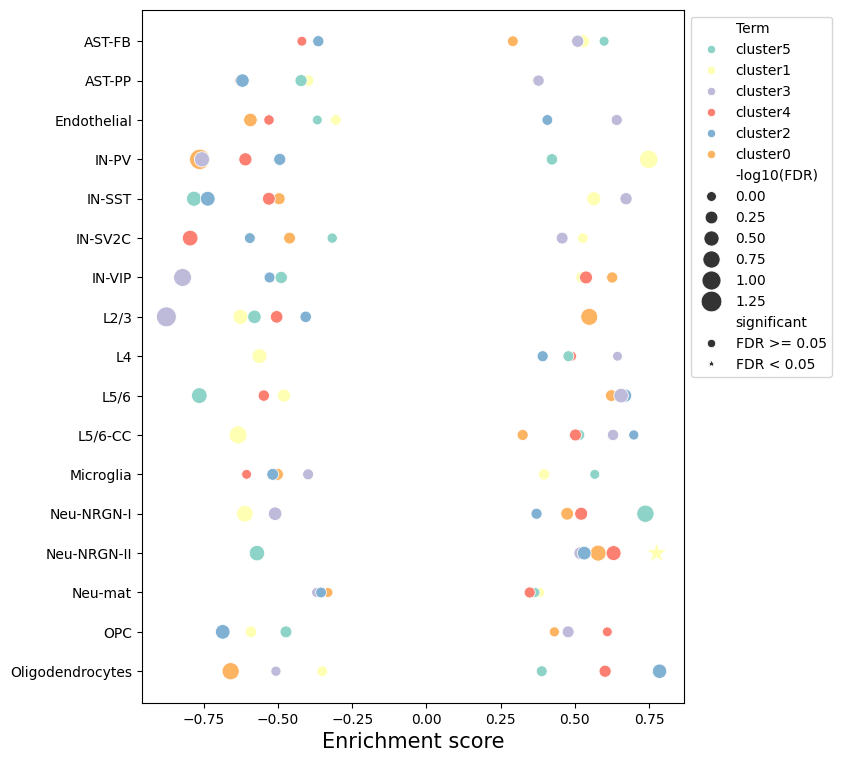

In [86]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

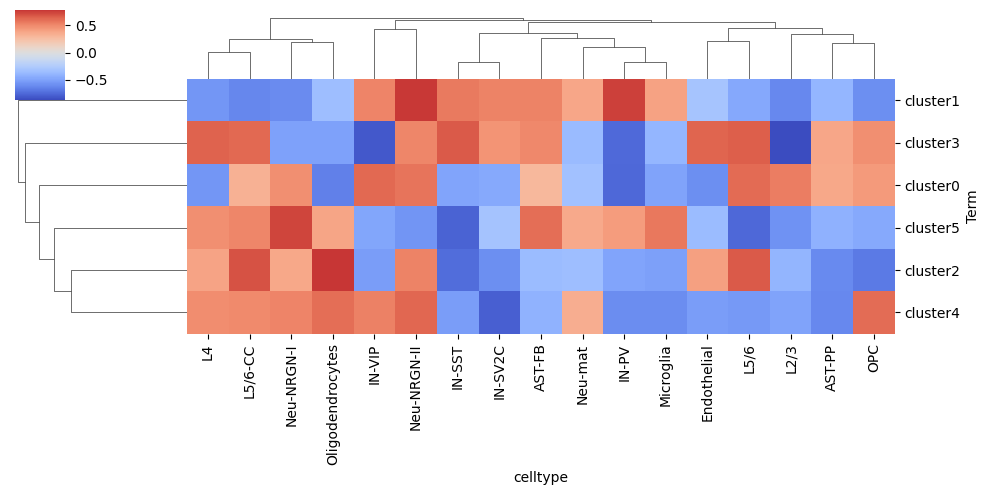

In [87]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

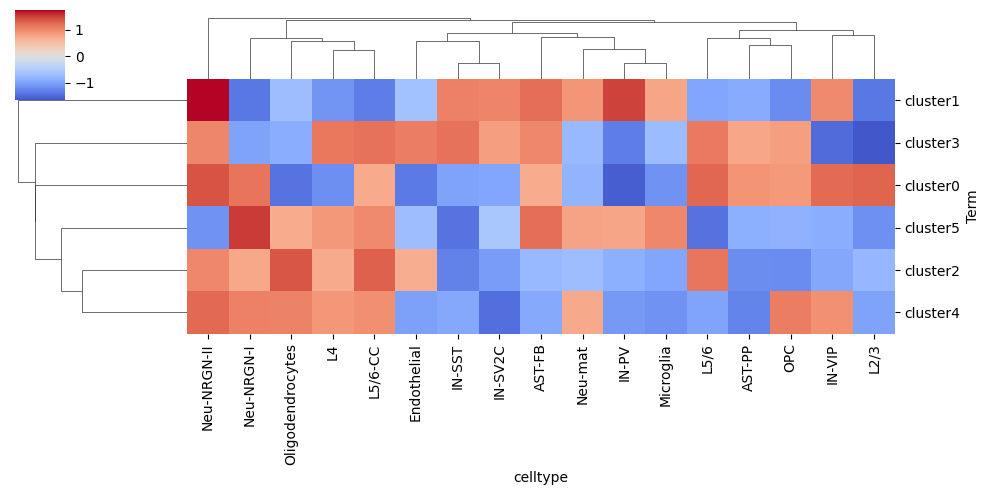

In [88]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### EdgeR

Run enrichment for genesets

In [89]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:34:17,568 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:18,941 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:23,192 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:25,366 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:26,990 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:28,320 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5   0.59829  1.213103  0.237347  0.987583       0.61   3/8   
1  prerank  cluster1  0.526581  1.202288  0.244628  0.519203       0.63  6/13   

   Gene %                             Lead_genes celltype  
0   5.32%                       LHX2;CHST10;ETFB   AST-FB  
1  19.45%  NDUFB7;NDUFB10;GAD1;TCEAL4;PSMB7;AMZ2   AST-FB

Process enrichment results

In [90]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5   0.59829  1.213103  0.237347  0.987583       0.61   3/8   
1  prerank  cluster1  0.526581  1.202288  0.244628  0.519203       0.63  6/13   

   Gene %                             Lead_genes celltype  -log10(FDR)  \
0   5.32%                       LHX2;CHST10;ETFB   AST-FB     0.004987   
1  19.45%  NDUFB7;NDUFB10;GAD1;TCEAL4;PSMB7;AMZ2   AST-FB     0.283827   

  direction  significant  
0  enriched  FDR >= 0.05  
1  enriched  FDR >= 0.05

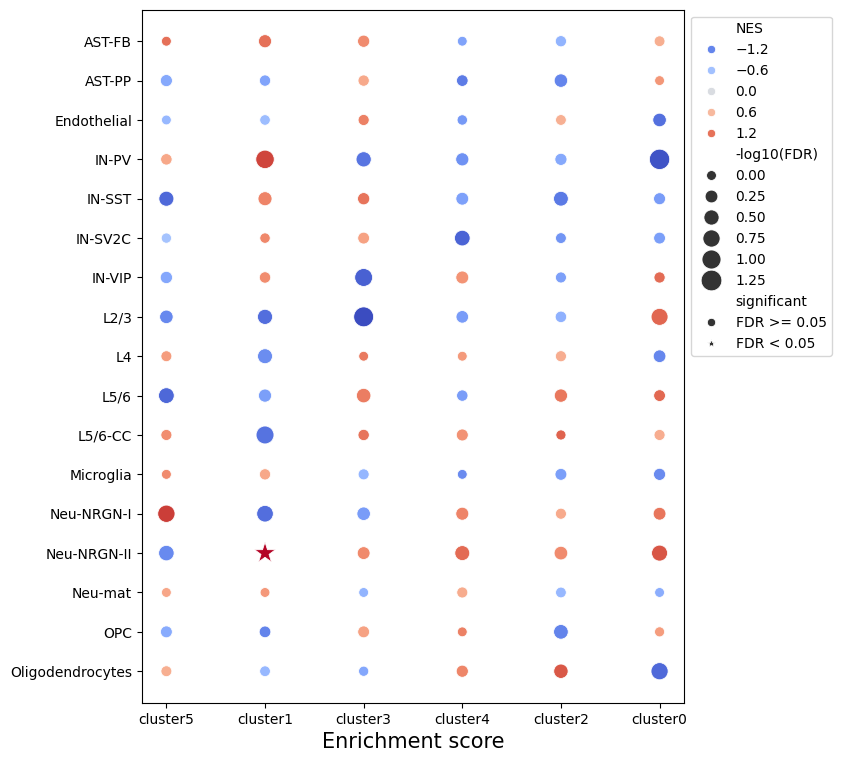

In [91]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_17896\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


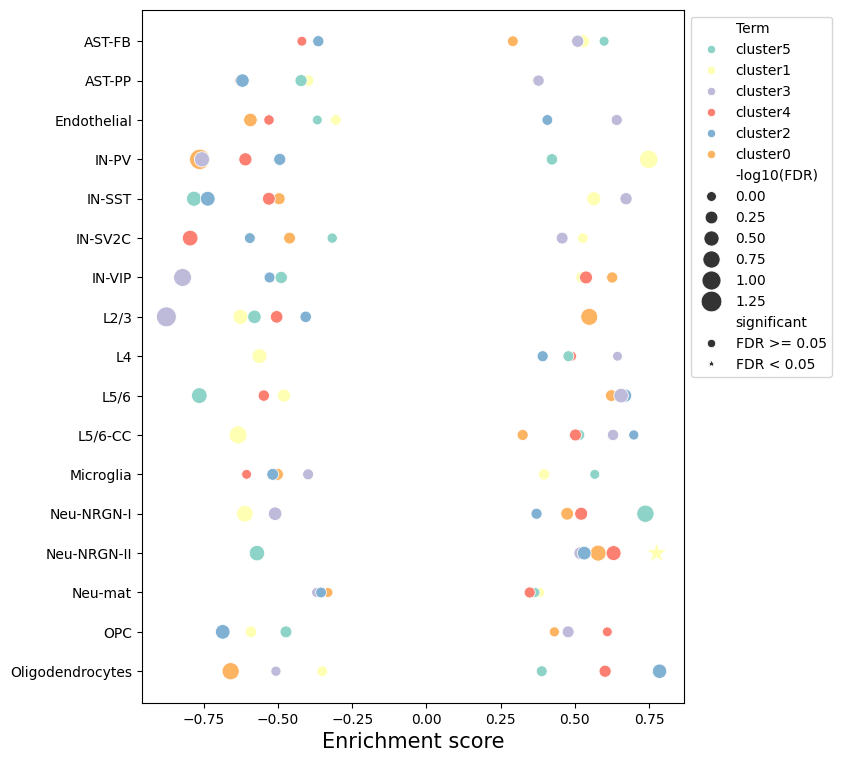

In [92]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

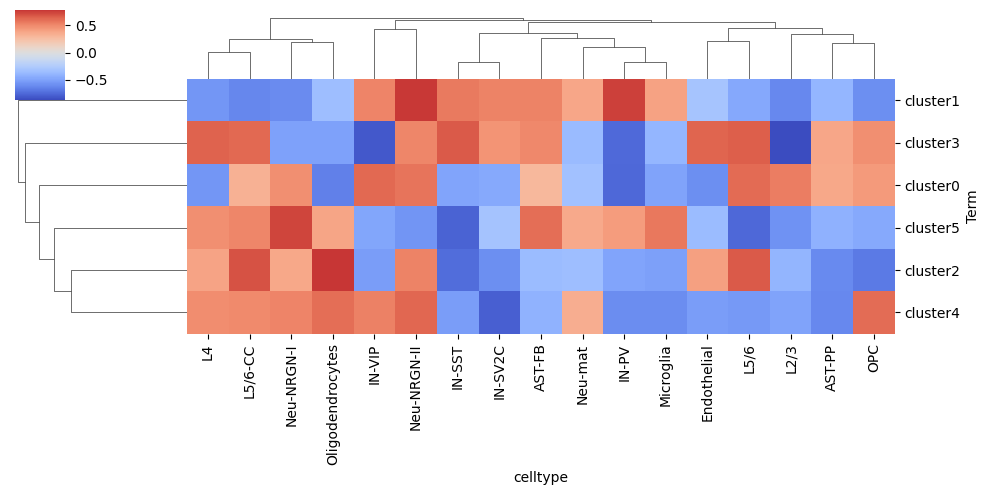

In [93]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

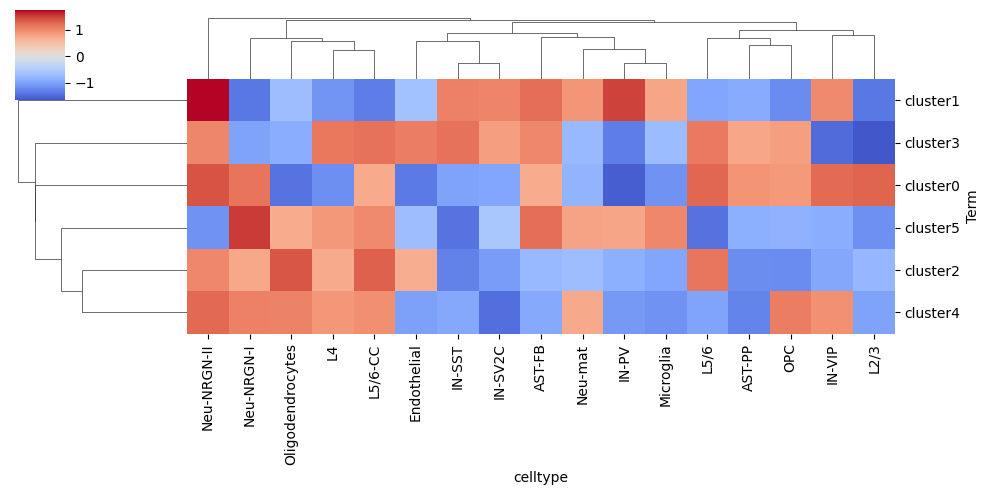

In [94]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

### Gene visualization

Calculate average normalized expression

In [95]:
for cluster in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cluster])
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  ...  \
cell                                                        ...   
AAACCTGGTACGCACC-1_1823_BA24                            18  ...   
AAACGGGCACCAGATT-1_1823_BA24                            18  ...   
AAAGATGAGTCCAGGA-1_1823_BA24                            18  ...   
AAAGATGTCTTGAGGT-1_1823_BA24                            18  ...   
AAAGCAAGTAATCACC-1_1823_BA24                            18  ...   

                              age-specific_scaled  maybe age-specific_scaled  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24             0.080602                   0.073885   
AAACGGGCACCAGATT-1_1823_BA24             0.336339                   0.302790   
AAAGATGAGTCCAGGA-1_1823_BA24            -0.208213                  -0.117305   
AAAGATGTCTTGAGGT-1_1823_BA24             0.051992                  -0.025779   
AAAGCAAGTAATCACC-1_1823_BA24            -0.324373                  -0.093362   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.755120   
AAACGGGCACCAGATT-1_1823_BA24                     0.239773   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.311614   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.343143   
AAAGCAAGTAATCACC-1_1823_BA24                     0.130890   

                              human-specific_scaled  cluster0_scaled  \
cell                                                                   
AAACCTGGTACGCACC-1_1823_BA24              -0.237940         0.037349   
AAACGGGCACCAGATT-1_1823_BA24               0.294932         0.216083   
AAAGATGAGTCCAGGA-1_1823_BA24              -0.237940        -0.257948   
AAAGATGTCTTGAGGT-1_1823_BA24               0.371973         0.335653   
AAAGCAAGTAATCACC-1_1823_BA24               0.240934        -0.071154   

                              cluster1_scaled  cluster2_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24        -0.301604         0.527176   
AAACGGGCACCAGATT-1_1823_BA24         0.304270         0.513361   
AAAGATGAGTCCAGGA-1_1823_BA24        -0.301604        -0.022719   
AAAGATGTCTTGAGGT-1_1823_BA24        -0.097398        -0.155459   
AAAGCAAGTAATCACC-1_1823_BA24        -0.301604         0.383623   

                              cluster3_scaled  cluster4_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24         1.031224        -0.044849   
AAACGGGCACCAGATT-1_1823_BA24         0.492005         0.501565   
AAAGATGAGTCCAGGA-1_1823_BA24         0.612303         0.042652   
AAAGATGTCTTGAGGT-1_1823_BA24         0.166398        -0.181013   
AAAGCAAGTAATCACC-1_1823_BA24        -0.580181         0.317545   

                              cluster5_scaled  
cell                                           
AAACCTGG

Vusualize

In [96]:
scaled_adata.obs.columns

Index(['cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis',
       'Capbatch', 'Seqbatch', 'post-mortem interval (hours)',
       'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent',
       'RNA ribosomal percent', 'human_specific_scaled', 'age-specific_scaled',
       'maybe age-specific_scaled', 'maybe human-specific_scaled',
       'human-specific_scaled', 'cluster0_scaled', 'cluster1_scaled',
       'cluster2_scaled', 'cluster3_scaled', 'cluster4_scaled',
       'cluster5_scaled'],
      dtype='object')

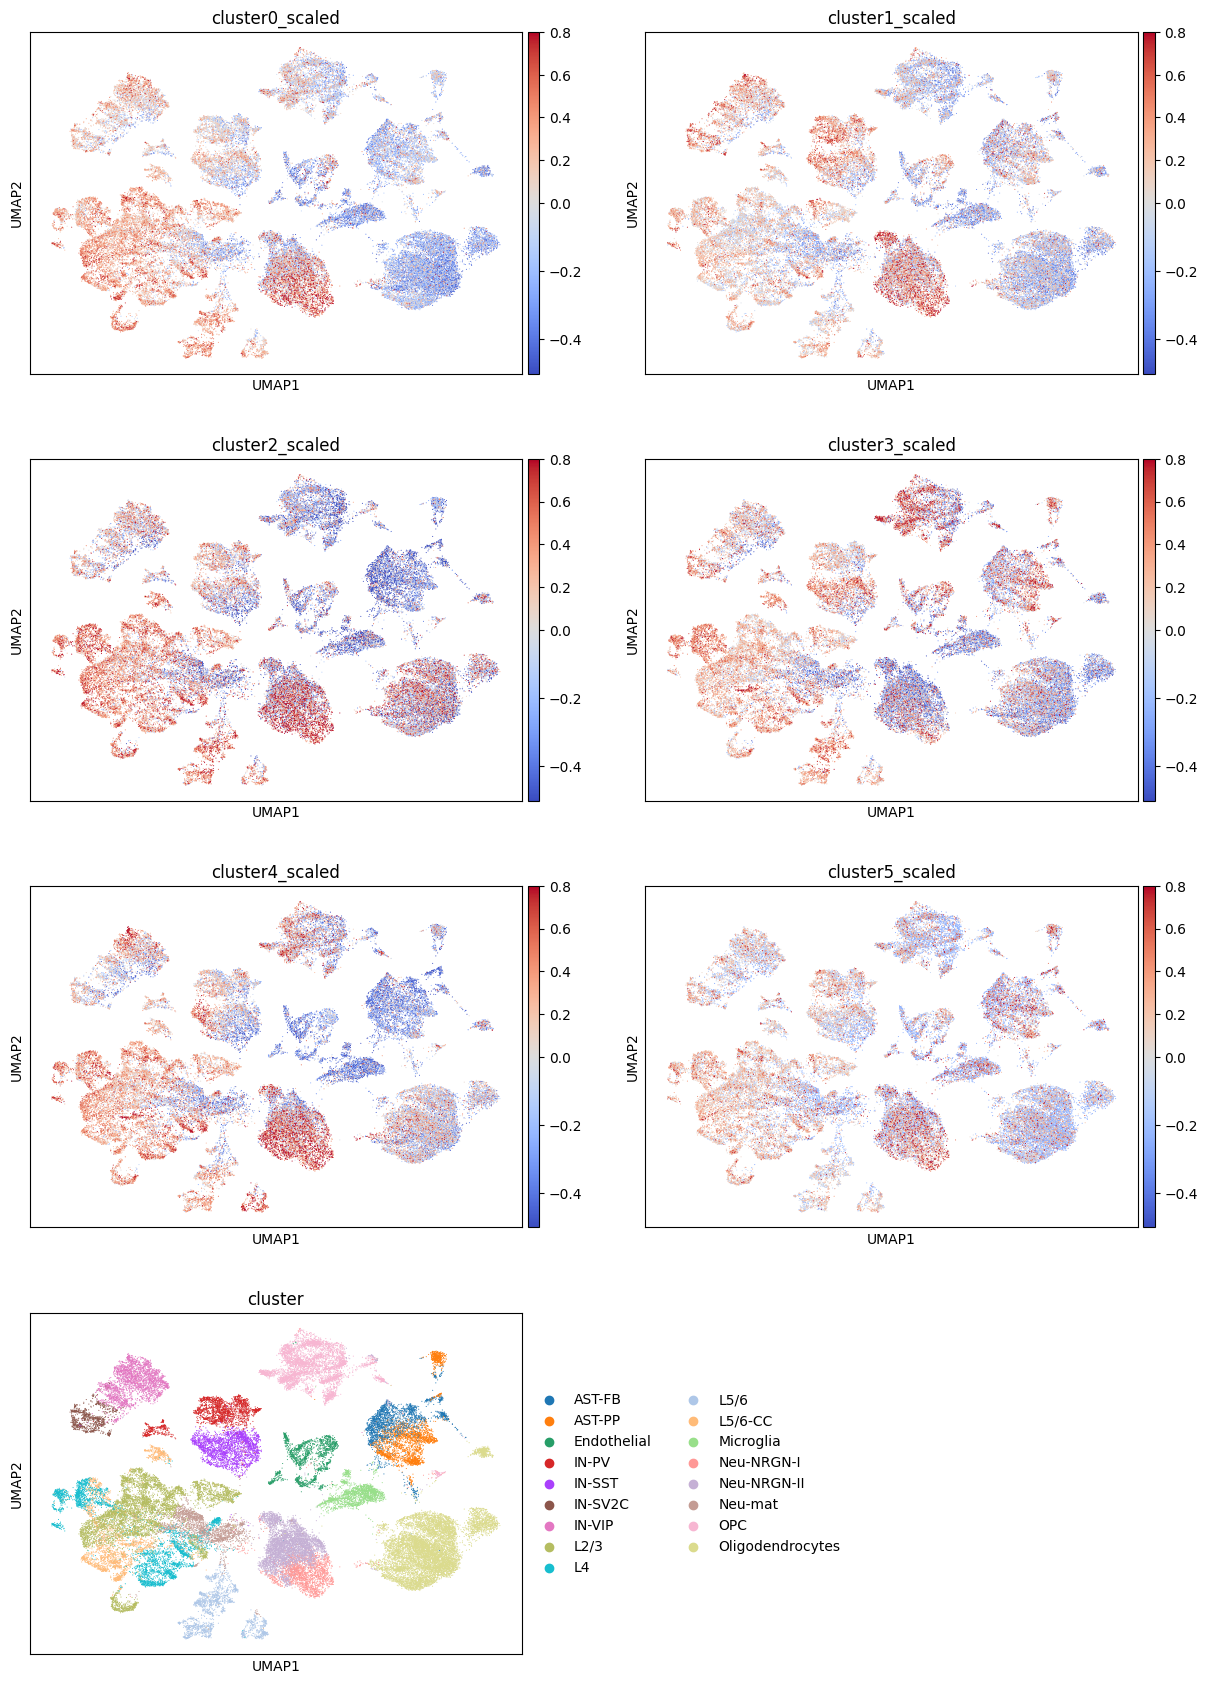

In [97]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.8, vmin=-0.5)
color = [
    'cluster0_scaled', 
    'cluster1_scaled',
    'cluster2_scaled', 
    'cluster3_scaled', 
    'cluster4_scaled',
    'cluster5_scaled', 
    'cluster'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

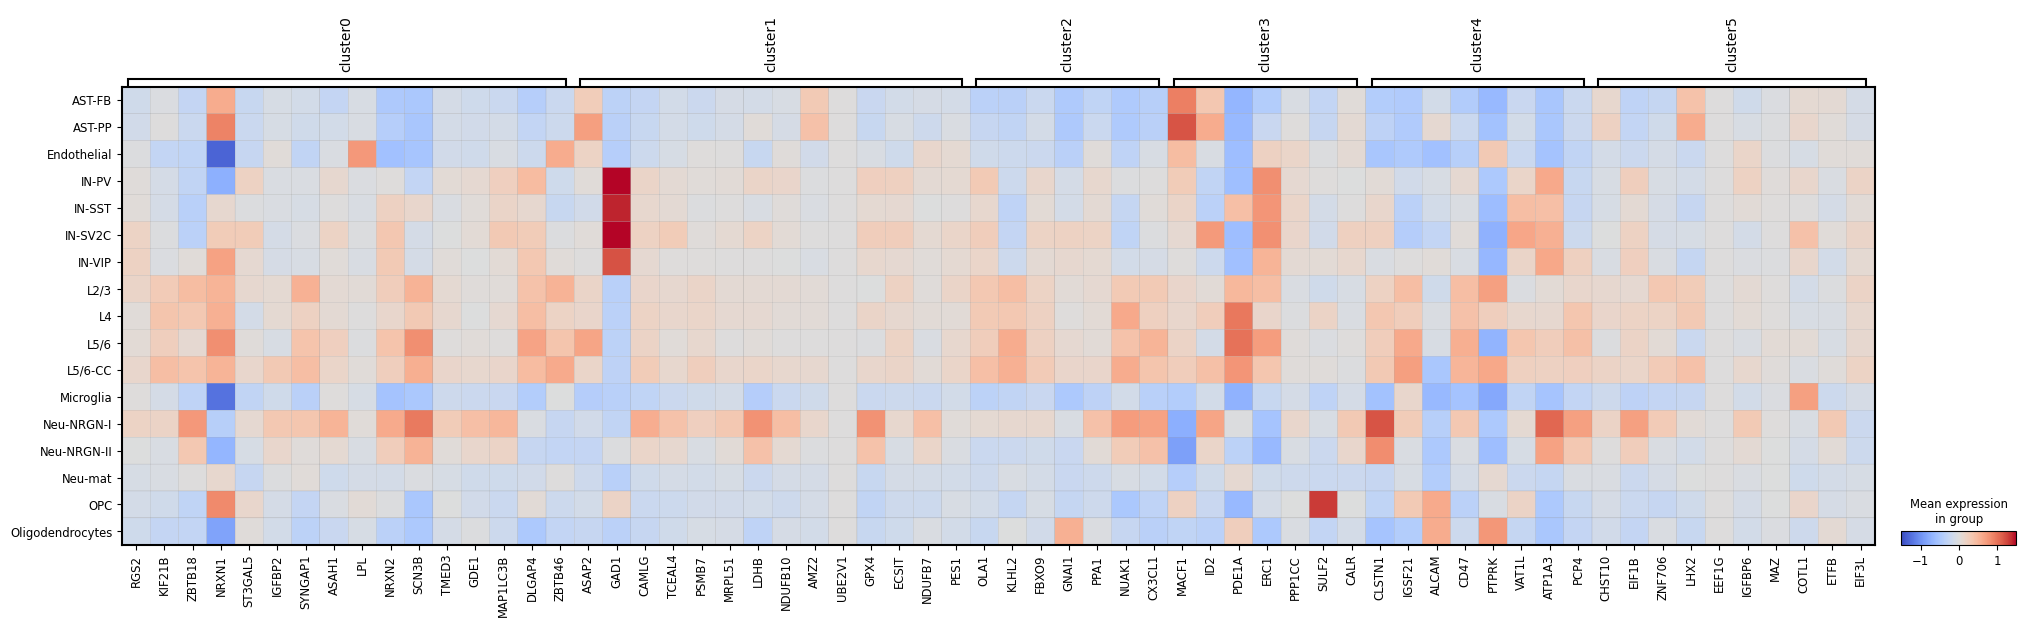

In [98]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

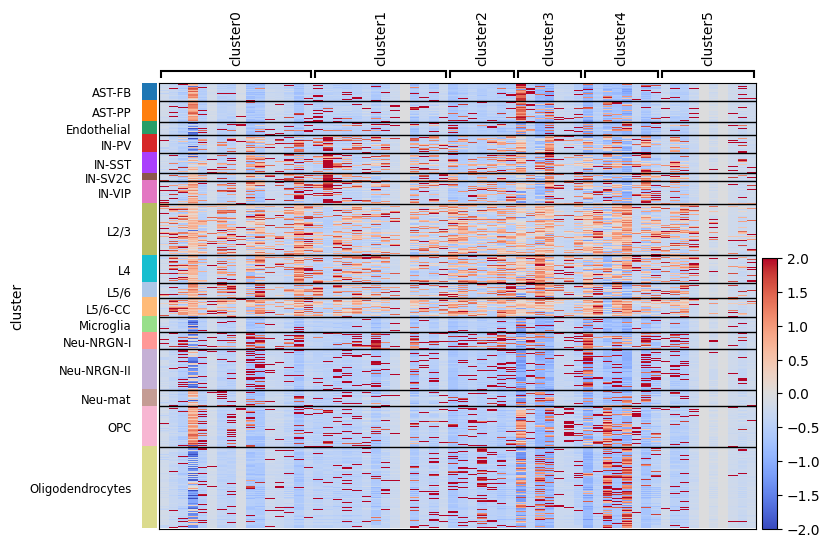

In [99]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

## Enrichment for chimp-specific genes

Create a dict with genesets

In [100]:
geneset = {'chimp-specific genes': chimp_specific_genes}

### T-test

Specify DE test

In [101]:
key = 't-test'

Run enrichment for genesets

In [102]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:34:53,673 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:54,954 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:34:57,670 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:00,495 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:03,069 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:04,469 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes   0.69217  1.725071  0.012755  0.012755   
0  prerank  chimp-specific genes  0.588901  1.487169  0.047468  0.047468   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0      0.005  7/13  9.08%  SLC1A3;TPD52L1;BPTF;HTRA1;BCL6;MASP1;SEMA3A   
0      0.015  7/13  7.86%  SLC1A3;HTRA1;TPD52L1;BCL6;BPTF;MASP1;SEMA3A   

  celltype  
0   AST-FB  
0   AST-PP

Process enrichment results

In [103]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes   0.69217  1.725071  0.012755  0.012755   
0  prerank  chimp-specific genes  0.588901  1.487169  0.047468  0.047468   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0      0.005  7/13  9.08%  SLC1A3;TPD52L1;BPTF;HTRA1;BCL6;MASP1;SEMA3A   
0      0.015  7/13  7.86%  SLC1A3;HTRA1;TPD52L1;BCL6;BPTF;MASP1;SEMA3A   

  celltype  -log10(FDR) direction significant  
0   AST-FB     1.861536  enriched  FDR < 0.05  
0   AST-PP     1.314542  enriched  FDR < 0.05

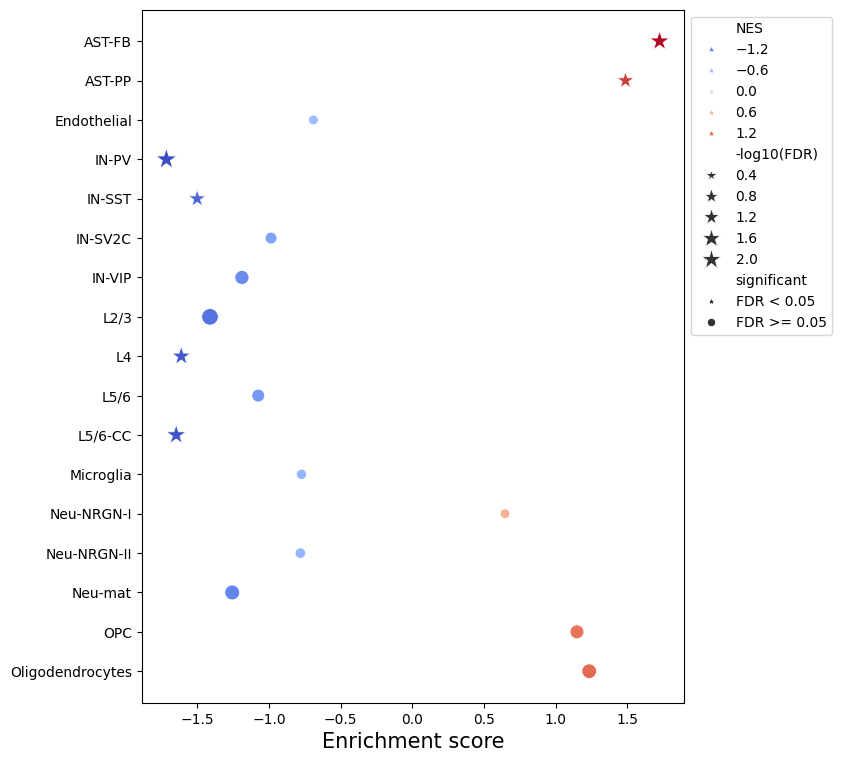

In [104]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [105]:
key = 'wilcoxon'

Run enrichment for genesets

In [106]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:35:16,178 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:17,607 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:18,877 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:20,122 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:21,410 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:22,699 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.784535  1.589015  0.010959  0.010959   
0  prerank  chimp-specific genes  0.694579   1.42095  0.075881  0.075881   

  FWER p-val Tag % Gene %                       Lead_genes celltype  
0      0.004  5/13  3.13%  SLC1A3;MASP1;TPD52L1;BCL6;HTRA1   AST-FB  
0      0.028  5/13  2.14%  SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   AST-PP

Process enrichment results

In [107]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.784535  1.589015  0.010959  0.010959   
0  prerank  chimp-specific genes  0.694579   1.42095  0.075881  0.075881   

  FWER p-val Tag % Gene %                       Lead_genes celltype  \
0      0.004  5/13  3.13%  SLC1A3;MASP1;TPD52L1;BCL6;HTRA1   AST-FB   
0      0.028  5/13  2.14%  SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   AST-PP   

   -log10(FDR) direction  significant  
0     1.922309  enriched   FDR < 0.05  
0     1.114182  enriched  FDR >= 0.05

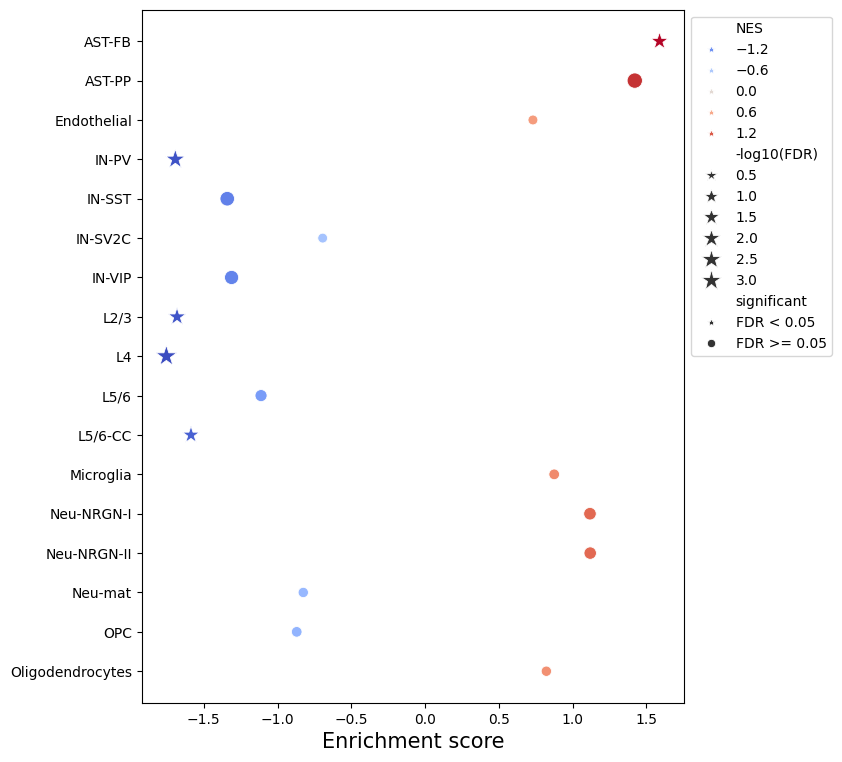

In [108]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [109]:
key = 'logreg'

Run enrichment for genesets

In [110]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:35:40,028 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:41,266 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:44,958 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:46,174 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:47,506 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:35:48,634 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.757944  1.779385  0.003534  0.003534   
0  prerank  chimp-specific genes  0.505918  1.173921  0.251656  0.251656   

  FWER p-val Tag % Gene %                         Lead_genes celltype  
0      0.002  6/13  3.64%  SPARC;MASP1;ANK3;SLC1A3;BCL6;BPTF   AST-FB  
0      0.114  3/13  0.79%               SLC1A3;TPD52L1;HTRA1   AST-PP

Process enrichment results

In [111]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.757944  1.779385  0.003534  0.003534   
0  prerank  chimp-specific genes  0.505918  1.173921  0.251656  0.251656   

  FWER p-val Tag % Gene %                         Lead_genes celltype  \
0      0.002  6/13  3.64%  SPARC;MASP1;ANK3;SLC1A3;BCL6;BPTF   AST-FB   
0      0.114  3/13  0.79%               SLC1A3;TPD52L1;HTRA1   AST-PP   

   -log10(FDR) direction  significant  
0     2.343560  enriched   FDR < 0.05  
0     0.597471  enriched  FDR >= 0.05

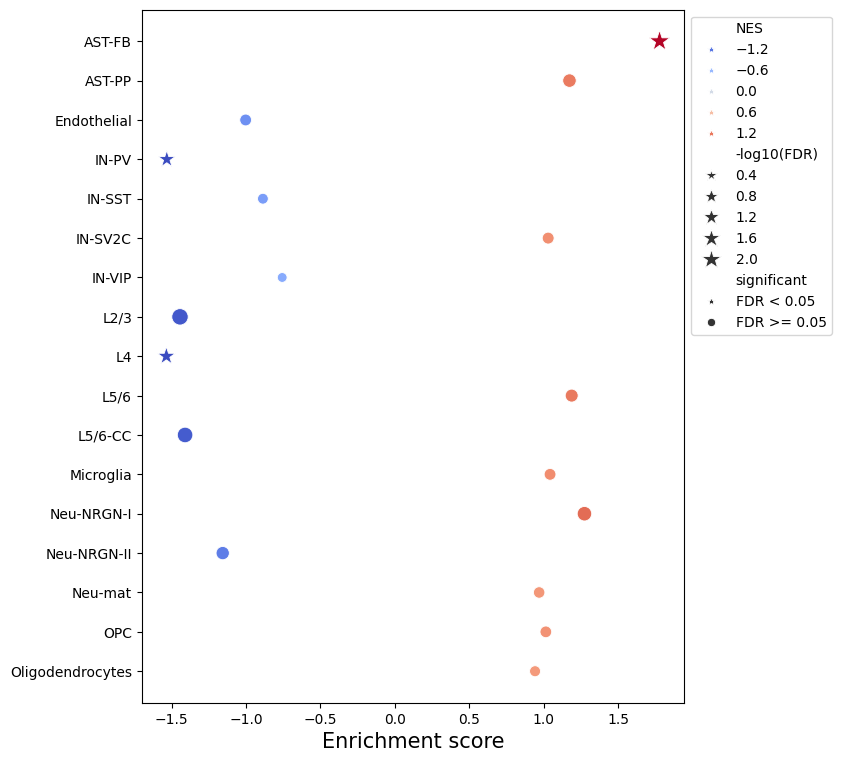

In [112]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [113]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/17 [00:00<?, ?it/s]

2024-06-20 18:36:00,768 [WARNING] Duplicated values found in preranked stats: 2.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:36:00,769 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:36:00,773 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-06-20 18:36:00,774 [INFO] 0001 gene_sets used for further statistical testing.....
2024-06-20 18:36:00,775 [INFO] Start to run GSEA...Might take a while..................
2024-06-20 18:36:02,252 [INFO] Congratulations. GSEApy runs successfully................

2024-06-20 18:36:02,270 [WARNING] Duplicated values found in preranked stats: 1.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-20 18:36:02,272 [INFO] Parsing data files for GSEA.............................
2024-06-20 18:36:02,276 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.897519   1.31029  0.111987  0.111987   
0  prerank  chimp-specific genes  0.878749  1.282539  0.143505  0.143505   

  FWER p-val Tag % Gene %                       Lead_genes celltype  
0      0.071  5/13  2.54%  SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   AST-FB  
0      0.095  5/13  2.90%  SLC1A3;TPD52L1;HTRA1;BCL6;MASP1   AST-PP

Process enrichment results

In [114]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.897519   1.31029  0.111987  0.111987   
0  prerank  chimp-specific genes  0.878749  1.282539  0.143505  0.143505   

  FWER p-val Tag % Gene %                       Lead_genes celltype  \
0      0.071  5/13  2.54%  SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   AST-FB   
0      0.095  5/13  2.90%  SLC1A3;TPD52L1;HTRA1;BCL6;MASP1   AST-PP   

   -log10(FDR) direction  significant  
0     0.946970  enriched  FDR >= 0.05  
0     0.840119  enriched  FDR >= 0.05

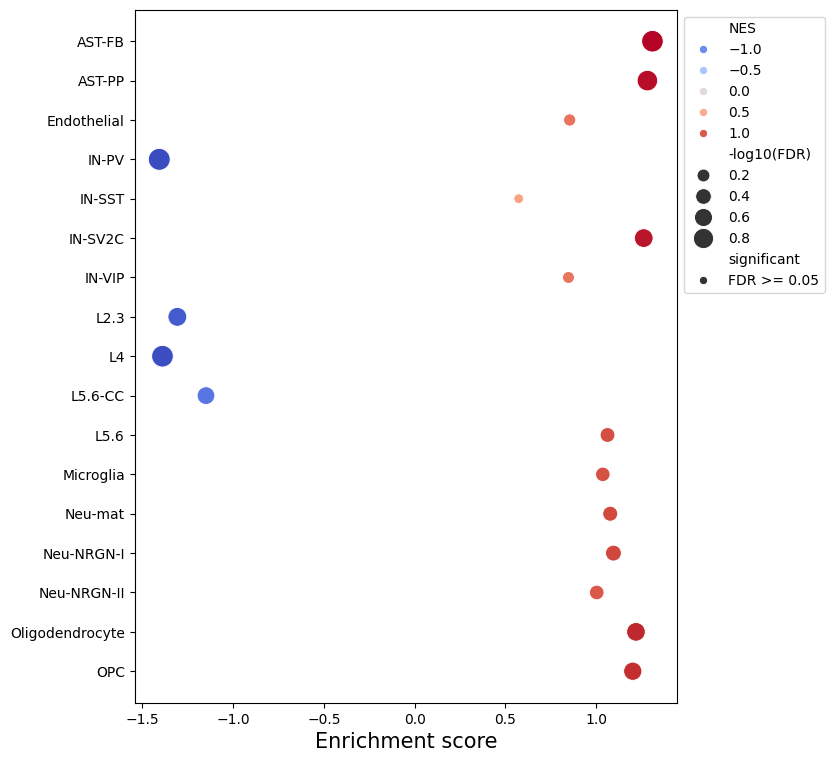

In [115]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [116]:
genes = scaled_adata.var_names.intersection(chimp_specific_genes)
scaled_adata.obs[f'chimp_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

C:\Users\claptar\AppData\Local\Temp\ipykernel_17896\2996626235.py:2: RuntimeWarning: Mean of empty slice.
  scaled_adata.obs[f'chimp_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
c:\projects\spatialMPFC\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  ...  \
cell                                                        ...   
AAACCTGGTACGCACC-1_1823_BA24                            18  ...   
AAACGGGCACCAGATT-1_1823_BA24                            18  ...   
AAAGATGAGTCCAGGA-1_1823_BA24                            18  ...   
AAAGATGTCTTGAGGT-1_1823_BA24                            18  ...   
AAAGCAAGTAATCACC-1_1823_BA24                            18  ...   

                              maybe age-specific_scaled  \
cell                                                      
AAACCTGGTACGCACC-1_1823_BA24                   0.073885   
AAACGGGCACCAGATT-1_1823_BA24                   0.302790   
AAAGATGAGTCCAGGA-1_1823_BA24                  -0.117305   
AAAGATGTCTTGAGGT-1_1823_BA24                  -0.025779   
AAAGCAAGTAATCACC-1_1823_BA24                  -0.093362   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.755120   
AAACGGGCACCAGATT-1_1823_BA24                     0.239773   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.311614   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.343143   
AAAGCAAGTAATCACC-1_1823_BA24                     0.130890   

                              human-specific_scaled  cluster0_scaled  \
cell                                                                   
AAACCTGGTACGCACC-1_1823_BA24              -0.237940         0.037349   
AAACGGGCACCAGATT-1_1823_BA24               0.294932         0.216083   
AAAGATGAGTCCAGGA-1_1823_BA24              -0.237940        -0.257948   
AAAGATGTCTTGAGGT-1_1823_BA24               0.371973         0.335653   
AAAGCAAGTAATCACC-1_1823_BA24               0.240934        -0.071154   

                              cluster1_scaled  cluster2_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24        -0.301604         0.527176   
AAACGGGCACCAGATT-1_1823_BA24         0.304270         0.513361   
AAAGATGAGTCCAGGA-1_1823_BA24        -0.301604        -0.022719   
AAAGATGTCTTGAGGT-1_1823_BA24        -0.097398        -0.155459   
AAAGCAAGTAATCACC-1_1823_BA24        -0.301604         0.383623   

                              cluster3_scaled  cluster4_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24         1.031224        -0.044849   
AAACGGGCACCAGATT-1_1823_BA24         0.492005         0.501565   
AAAGATGAGTCCAGGA-1_1823_BA24         0.612303         0.042652   
AAAGATGTCTTGAGGT-1_1823_BA24         0.166398        -0.181013   
AAAGCAAGTAATCACC-1_1823_BA24        -0.580181         0.317545   

                              cluster5_scaled  chimp_specific_scaled  
cell                                                                  
AAACCTGGTACGCACC-1_1823_BA24         0.251751                    NaN  
AAACGGGCACCAGATT-1_1823_BA24         0

Vusualize